### Práctica 4: Selección de variables 

En esta ocasión lo que vamos a hacer es utilziar un conjunto de datos nuevo y diferente, ya que para exponer lo aprendido en la teoría de esta parte, se requiere la aplicación algoritmos muy costosos computacionalmente. El nuevo dataset es mucho más ligero que el anterior con unos pocos miles de registros mientras que el de los ejercicios anteriores era muy masivo. 

Vamos a tratar de mostar algunos de los mecanismos de selección de variables con los que contamos a la hora de hacer esa operación de selección. Especialmente útil cuando estamos optimizando nuestro modelo para mejorarlo o para reducir su dimensionalidad.

#### 1. Preparación de los datos

En primer lugar vamos a importar las librerías de python que seran necesarias para realziar el analisis y cargar el conjunto de datos que habrá que preparar y limpiar antes de hacer nada con ellos. El dataset consiste en un conjunto de registros, cada uno correspondiente a un paciente con una serie de métricas sobre su estado de salud en distintas aspectos como tensión, colesterol, diabetes, etc. Otros datos son sobre el paciente como la edad, nivel de estudios o si fuma o no. Nuestra variable objetivo es predecir si en 10 años el paciente sufrirá con alta probabildiad una enfermedad coronaria.

In [222]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression 
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from scipy.stats import boxcox, shapiro, chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, RegressorMixin
from itertools import combinations
from statsmodels.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import (  
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report
)
from sklearn.utils import resample # Para realizar muestreos aleatorios
from mlxtend.feature_selection import SequentialFeatureSelector as SFS # Importa el selector de características secuencial, perimte seleccionar características automáticamente hacia adelante o hacia atrás.
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs # Importa la función para graficar el proceso de selección secuencia de característicasx
from statsmodels.api import Logit # Importa el modelo de regresión logística
from sklearn.preprocessing import StandardScaler, MinMaxScaler #Importa dos técnicas de escalado de datos: Estandarización y normalización
from imblearn.over_sampling import SMOTE, SMOTENC #Importa métodos de sobremuestreo para datos desbalanceados

In [223]:
# Configuración que permite mostrar todas las filas y columnas
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

# Cargar el dataset desde el archivo csv
data = pd.read_csv('Datos/ch_disease.csv')


En primer lugar vamos a echar un vistazo al dataset

In [224]:
# Realizar una descprición incial del dataset
data.info() # Información general de las columnas, tipos de datos y no nulos.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4238 non-null   int64  
 1   age              4238 non-null   int64  
 2   education        4133 non-null   float64
 3   currentSmoker    4238 non-null   int64  
 4   cigsPerDay       4209 non-null   float64
 5   BPMeds           4185 non-null   float64
 6   prevalentStroke  4238 non-null   int64  
 7   prevalentHyp     4238 non-null   int64  
 8   diabetes         4238 non-null   int64  
 9   totChol          4188 non-null   float64
 10  sysBP            4238 non-null   float64
 11  diaBP            4238 non-null   float64
 12  BMI              4219 non-null   float64
 13  heartRate        4237 non-null   float64
 14  glucose          3850 non-null   float64
 15  TenYearCHD       4238 non-null   int64  
dtypes: float64(9), int64(7)
memory usage: 529.9 KB


Tenemos un total de 4.238 registros con 15 variables. Se puede ver que <b> *tenemos algunos valores nulos* </b> en algunas de las variables, por lo que habrá que tratarlos para que no nos generen inconsistencias ni errores o similar.

<b> Queremos predecir el TenYearCHD, que es la probabilidad de tener problemas cardiovasculares</b>

In [225]:
# Estadísticas descriptivas (media, std, min, max, etc.0)
data.describe()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,4238.000000,4238.000000,4133.000000,4238.000000,4209.000000,4185.000000,4238.000000,4238.000000,4238.000000,4188.000000,4238.000000,4238.000000,4219.000000,4237.000000,3850.000000,4238.000000
mean,0.429212,49.584946,1.978950,0.494101,9.003089,0.029630,0.005899,0.310524,0.025720,236.721585,132.352407,82.893464,25.802008,75.878924,81.966753,0.151958
std,0.495022,8.572160,1.019791,0.500024,11.920094,0.169584,0.076587,0.462763,0.158316,44.590334,22.038097,11.910850,4.080111,12.026596,23.959998,0.359023
min,0.000000,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,107.000000,83.500000,48.000000,15.540000,44.000000,40.000000,0.000000
25%,0.000000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,75.000000,23.070000,68.000000,71.000000,0.000000
50%,0.000000,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.000000,82.000000,25.400000,75.000000,78.000000,0.000000
75%,1.000000,56.000000,3.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,263.000000,144.000000,89.875000,28.040000,83.000000,87.000000,0.000000
max,1.000000,70.000000,4.000000,1.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.000000,142.500000,56.800000,143.000000,394.000000,1.000000


Se ven en los estadísticos generales que muchas de las variables son de valor 0 o 1, como <b>male</b> o <b>currentSmoker</b>, ya que los percentiles por debajo del 50 (incluido) son 0 y por encima son 1. Tenemos varias variables que son numericas con rangos de valores continuos como <b>totChol</b>, que muestra el colesterol en sangre o <b>sysBP</b> que indica el valor de tensión sistólica que tiene el paciente. 

Vamos a pintar unos histogramas de todas las variables para ver que pinta tienen sus distribuciones.

Variables numéricas:  ['male' 'age' 'education' 'currentSmoker' 'cigsPerDay' 'BPMeds'
 'prevalentStroke' 'prevalentHyp' 'diabetes' 'totChol' 'sysBP' 'diaBP'
 'BMI' 'heartRate' 'glucose' 'TenYearCHD']


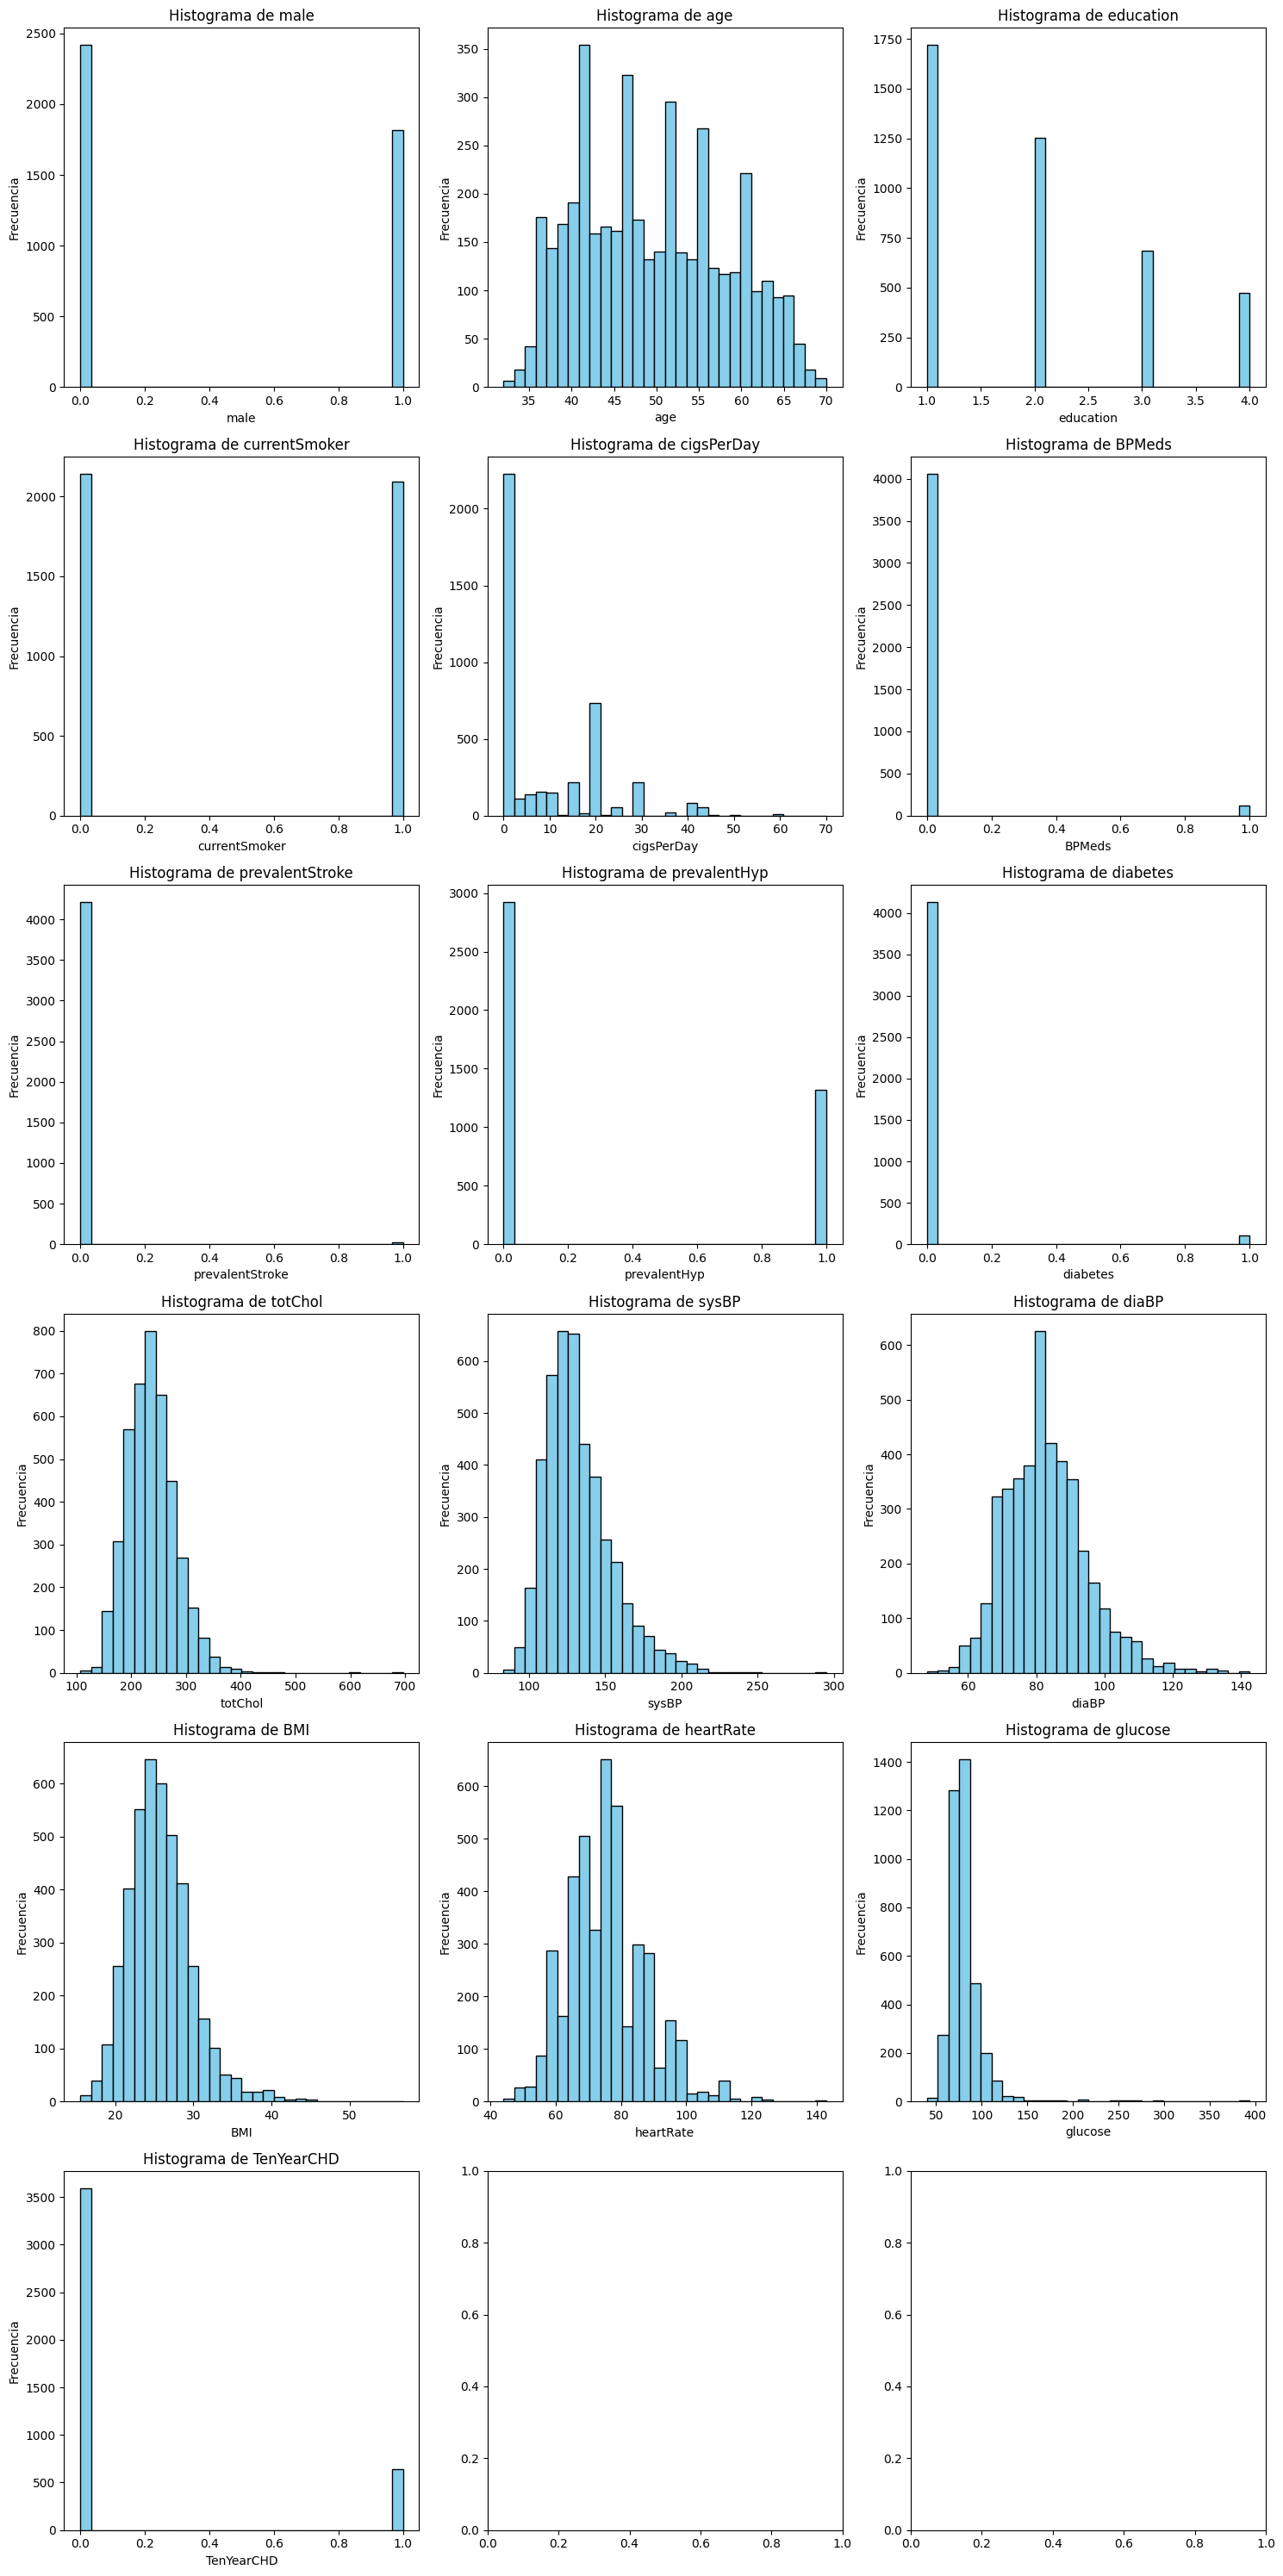

In [226]:
# Identificar las columnas numéricas 
numeric_columns = data.select_dtypes(include=[np.number]).columns
print('Variables numéricas: ', numeric_columns.values)

# Crear una figura con subplots 
num_vars = len(numeric_columns)
fig, axes = plt.subplots(nrows= (num_vars // 3) +1, ncols = 3, figsize = (15, 5 * ((num_vars // 3) +1 )))
axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    # Grafica el histograma
    axes[i].hist(data[col], bins=30, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Histograma de {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

Parece que en la muestra hay más mujeres que hombres al haber más 0 que 1 en la variable <b>male</b>. Las edades (<b>age</b>) se sitúan entre los 35 y los 70 años. Segun la variable <b>currentSmoker</b> tenemos tantos fumadores como no fumadores más o menos. La variable <b>BPMeds</b> parece que casi siempre es 0, es decir, que no hay muchos pacientes que estén tomando medicación para la tensión. Tampoco hay muchos pacientes que hayan presentado algún episodio cardiovascular en el pasado (<b>prevalentSrtoke</b>) o que tengan <b>diabetes</b>. Los histogramas de <b>totChol</b>(colesterol), tensión (<b>sysBP</b> y <b>diaBP</b>), el 
indice de masa corporal <b>BMI</b>, las pulsaciones (<b>hearRate</b>) o la <b>glucose</b>, parecen distribuciones más o menos normales sin outliers importantes. Por último, nuestra variable objetivo <b>TenYearCHD</b> está claramente desbalanceada al haber muy poquitas muestras de pacientes con enfermedad coronaria al cabo de 10 años.

In [227]:
# Función para contar los ceros en cada columna numérica
def count_zeros(df):

    # Contar ceros en cada columna numérica
    zero_counts = df[numeric_columns].apply(lambda x: (x==0).sum())

    return zero_counts
for i, col in enumerate(numeric_columns):
    # Llamar a la función para contar ceros
    zero_counts = count_zeros(data)
    print(f'Nuero de 0s en {col}: {zero_counts[col]}')

Nuero de 0s en male: 2419
Nuero de 0s en age: 0
Nuero de 0s en education: 0
Nuero de 0s en currentSmoker: 2144
Nuero de 0s en cigsPerDay: 2144
Nuero de 0s en BPMeds: 4061
Nuero de 0s en prevalentStroke: 4213
Nuero de 0s en prevalentHyp: 2922
Nuero de 0s en diabetes: 4129
Nuero de 0s en totChol: 0
Nuero de 0s en sysBP: 0
Nuero de 0s en diaBP: 0
Nuero de 0s en BMI: 0
Nuero de 0s en heartRate: 0
Nuero de 0s en glucose: 0
Nuero de 0s en TenYearCHD: 3594


Hay muchas variables que al ser binarias, tienen un alto número de valores 0. Las demás variables, aquellas que no son binarias y tienen rangos continuos, ninguna tiene valores 0.

In [228]:
# Calcular la cardinalidad de cada columna
cardinalities = data.nunique()
cardinalities.sort_values(ascending = False)

BMI                1363
totChol             248
sysBP               234
diaBP               146
glucose             143
heartRate            73
age                  39
cigsPerDay           33
education             4
prevalentHyp          2
BPMeds                2
currentSmoker         2
male                  2
prevalentStroke       2
diabetes              2
TenYearCHD            2
dtype: int64

Las cardinalidades nos confirman que efectivamente esas variables con 0s son las únicas que podemos considerar categoricas por ser binarias. Solo hay un caso <b>education</b> que podríamos consdierar tanto categórica como continua. AL codificarla podemos establecer un orden en sus valores ya que a mayor número, mayor nivel de educación o estudios previos. Pero esto ese decidirá más adelante.

In [229]:
# Identificar las variables categóricas, es decir aquellas con 4 o menos categorías
categorical_cols_reduced = cardinalities[cardinalities < 5].index

for column in categorical_cols_reduced:
    print(f'\n Frecuencia de la columna {column}:')
    print(data[column].value_counts())


 Frecuencia de la columna male:
male
0    2419
1    1819
Name: count, dtype: int64

 Frecuencia de la columna education:
education
1.0    1720
2.0    1253
3.0     687
4.0     473
Name: count, dtype: int64

 Frecuencia de la columna currentSmoker:
currentSmoker
0    2144
1    2094
Name: count, dtype: int64

 Frecuencia de la columna BPMeds:
BPMeds
0.0    4061
1.0     124
Name: count, dtype: int64

 Frecuencia de la columna prevalentStroke:
prevalentStroke
0    4213
1      25
Name: count, dtype: int64

 Frecuencia de la columna prevalentHyp:
prevalentHyp
0    2922
1    1316
Name: count, dtype: int64

 Frecuencia de la columna diabetes:
diabetes
0    4129
1     109
Name: count, dtype: int64

 Frecuencia de la columna TenYearCHD:
TenYearCHD
0    3594
1     644
Name: count, dtype: int64


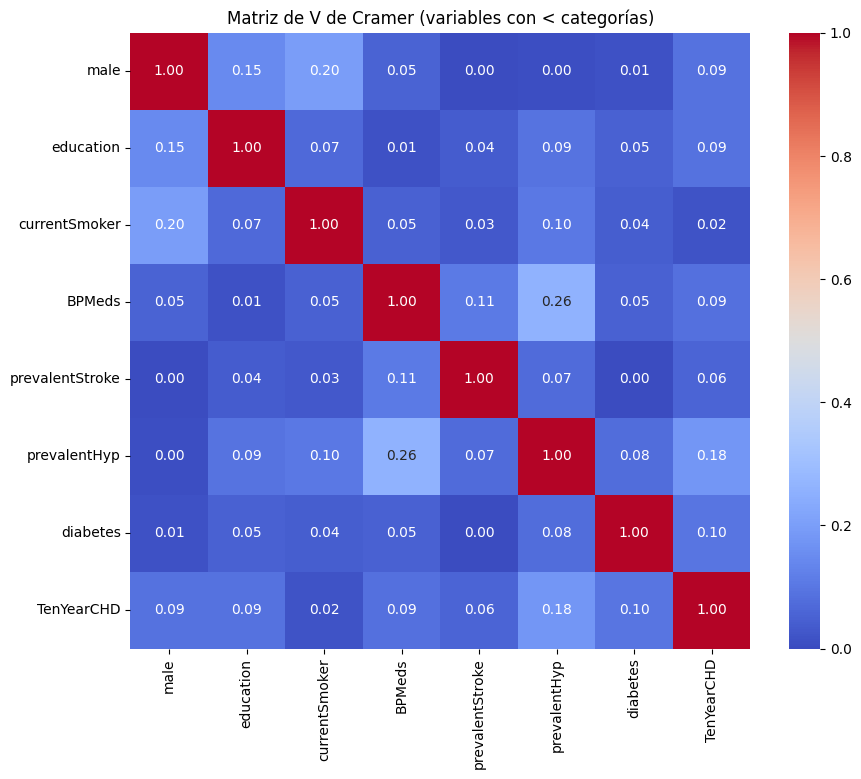

In [230]:
# Función para calcular V de Cramer
def cramers_v(confusion_matrix): 
    chi2, p, dof, expected =chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    k = min(confusion_matrix.shape)
    return np.sqrt(chi2 / (n *(k-1)))

# Crear una matriz vacía para almacenar los valores de V de Cramer
matrix = pd.DataFrame(index = categorical_cols_reduced, columns= categorical_cols_reduced)

# Cacular V de Cramer para cada par de variables categóricas
for var1, var2 in combinations(categorical_cols_reduced, 2):
    contingency_table = pd.crosstab(data[var1], data[var2])
    value = cramers_v(contingency_table)
    matrix.loc[var1, var2] = value
    matrix.loc[var2, var1] = value

# Llenar la diagonal con 1s
np.fill_diagonal(matrix.values,1)

# Convertir a tipo float
matrix = matrix.astype(float)

# Visualizar la matriz como heatmap 
plt.figure(figsize = (10,8))
sns.heatmap(matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de V de Cramer (variables con < categorías)')
plt.show()

Analizando la matriz de coeficientes de V de Cramer, vemos que en general ninguna variable categórica tiene nada que ver con ninguna otra. Quizá lo que pueda tener algo, y es en realidad muy poco, es la variable <b>prevalentHyp</b> com la variable <b>BPMeds</b>. Tiene sentido puesto que alguien que tiene antecedentes de hipertensión, se medique para ello. lo Bueno de estar incorreladas es que no habrá problemas en los modelos de dependencia lineal (multicolinealidad).

En cuanto a la relación con la variable objetivo <b>TenYearCHD</b>, no hay ninguna variable que supere un factor V de Cramer de 0.18. No hay mucha variable que explique la variabilidad de la objetivo. Esto pinta complicado para clasificar bien.

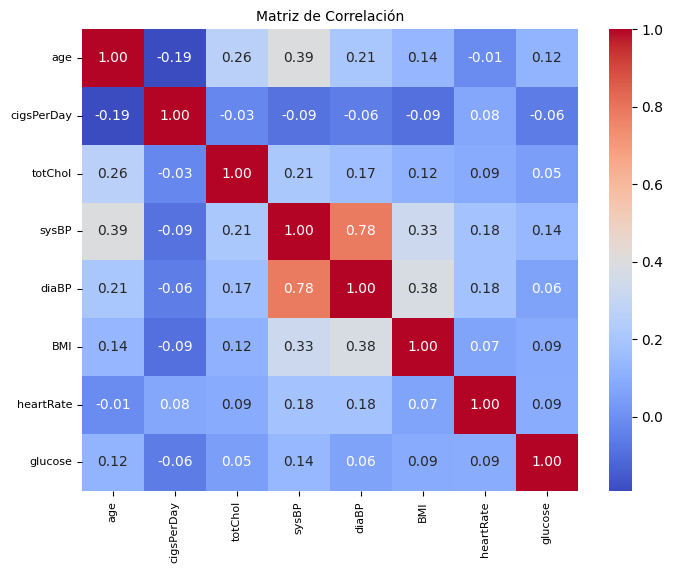

In [231]:
# Identificar las variables numericas, es decir, aquellas con mas de 4 categorías
numerical_cols_reduced = cardinalities[cardinalities > 4].index

# Correlación entre variables numéricas
correlation_matrix = data[numerical_cols_reduced].corr()

plt.figure(figsize=(8,6))

# Dibujar la matriz de correlación como un heatmap
sns.heatmap(correlation_matrix, annot=True, fmt= '.2f', cmap='coolwarm', cbar=True)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.title("Matriz de Correlación", fontsize=10)
plt.show()

Analizando las variables numéricas si que encontramos algunas relaciones entre ellas. Por ejemplo entre la tensión <b>sysBP</b> y la <b>diaBP</b> ya que suele ser habitual que si una sube, la otra tambien y viceversa. Estas 2 tienen un factor de correación alto (0.78). Por otro lado, otras relaciones como la edad <b>age</b> y la tensión sistólica <b>sysBP</b>, o el índice de masa corporal <b>BMI</b> con la tensión diastólica <b>diaBP</b> y la sitólica.

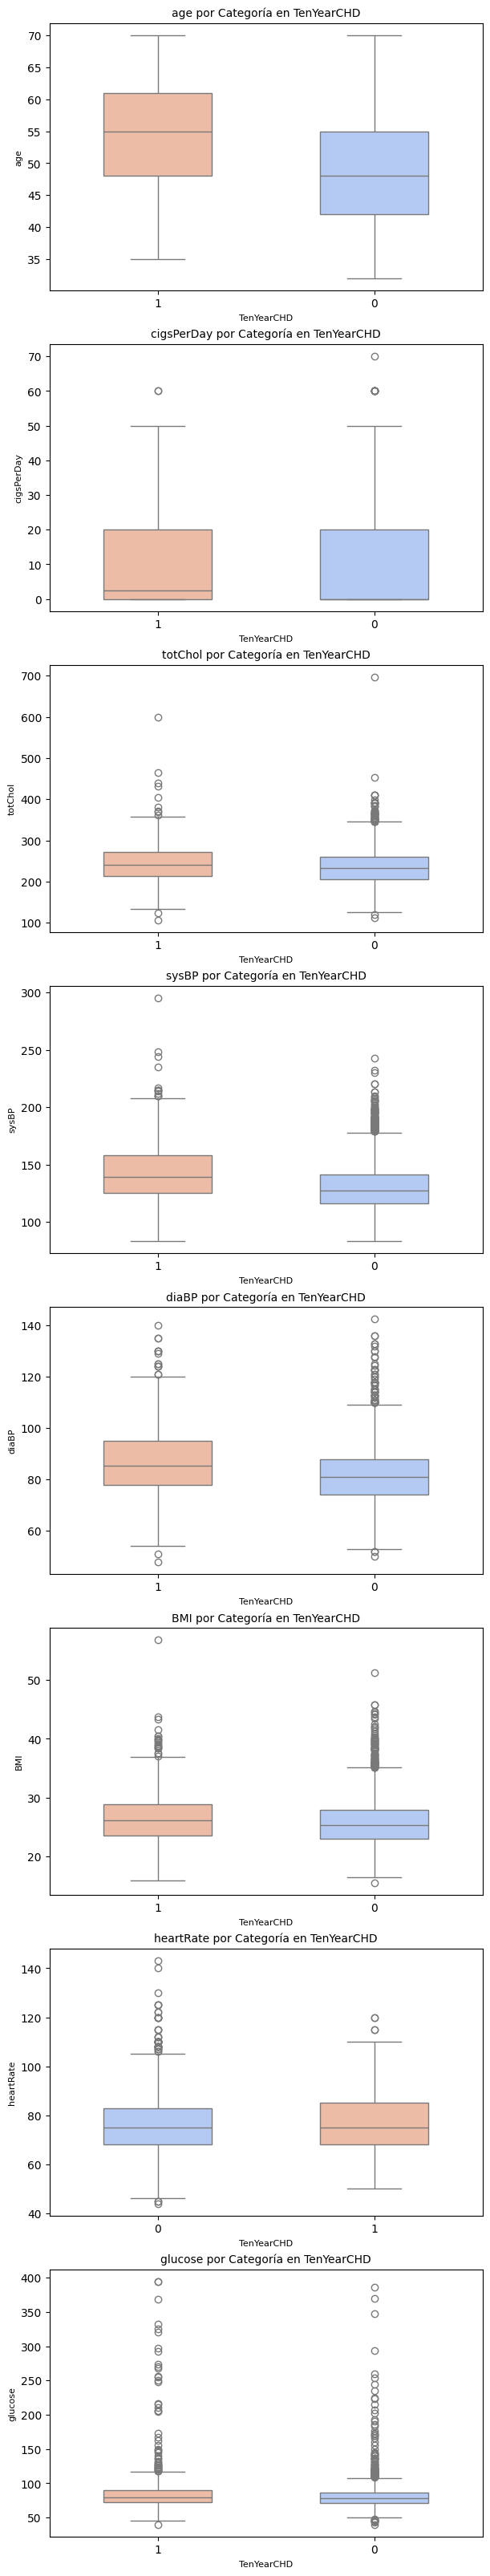

In [232]:
target_var = 'TenYearCHD'

# Crear el grid de subplots
n_vars = len(numerical_cols_reduced)
fig, axes = plt.subplots(n_vars, 1, figsize=(6, 4 * n_vars), constrained_layout = True )

# Generar un boxplot por cada variable nymerica 
for ax, var in zip(axes, numerical_cols_reduced):
    # Ordenar las categorías según la mediana calculada
    medians = data.groupby(target_var)[var].median().sort_values(ascending = False)
    ordered_categories = medians.index 

    # Generar el boxplot con las categorías ordenadas
    sns.boxplot(x= target_var, y=var, data=data, order=ordered_categories, palette='coolwarm', hue=target_var, legend=False, ax=ax, width =0.5)
    ax.set_title(f'{var} por Categoría en {target_var}', fontsize=10)
    ax.set_xlabel(target_var, fontsize=8)
    ax.set_ylabel(var, fontsize=8)

# Mostrar el grid boxplots 
plt.show()

En relación con muestra varianle objetivo, vemos que la edad puede tener algo de relación. Parece que los pacientes con enfermedad coronaria suelen ser mayores de edad que los que no. En relación con el colesterol <b>totChol</b> no parece que haya mucha relación, sin embargo con los valores de tensión sistólica <b>sysBP</b> si. Cuando mayor sea la tensión parece que más casos se dan. Igual pasa con la diastólica <b>diaBP</b>. El resto de variables no parecen tener mucha relación con nuestra variable objetivo.

In [233]:
# Análisis de Missing Values
missing_data = data.isnull().sum()
missing_data_percentage = (missing_data / len(data)) * 100

# Crear un DataFrame con ambas columnas
missing_summary = pd.DataFrame({'Missing values': missing_data, 'Percentage': missing_data_percentage})

# Mostrar resultados 
print('\nPorcentajes de valores faltantes por columna:')
missing_summary.sort_values(by='Percentage',ascending= False)


Porcentajes de valores faltantes por columna:


,Missing values,Percentage
glucose,388,9.155262
education,105,2.477584
BPMeds,53,1.250590
totChol,50,1.179802
cigsPerDay,29,0.684285
BMI,19,0.448325
heartRate,1,0.023596
male,0,0.000000
prevalentHyp,0,0.000000
prevalentStroke,0,0.000000


El análisis de valores nulos nos indica que las variables <b>glucose, education, BPmeds, totChol, BMI</b> y <b>hearRate</b>, tiene algun valor nulo. El resto no

In [234]:
# Contar valores null fila quitando la variable size
null_counts = data.isnull().sum(axis=1)

# Crear la tabla resumen
summary = null_counts.value_counts().reset_index()
summary.columns = ['num_nulls','count']
summary = summary.sort_values('num_nulls').reset_index(drop=True)

# Aplicar estilo con pandas styler para mostar en rojo num_nulls >= 6
def highlight_rows(s):
    color = 'background-color: red, color: white;' if s['num_nulls'] >= 6 else ''
    return [color] * len(s)

summary_styled = summary.style.apply(highlight_rows, axis=1)

# Mostrar resultado estilizado 
summary_styled

,num_nulls,count
0,0,3656
1,1,521
2,2,59
3,3,2


El número de nulos por fila es bajito. Como mucho tenemos 2 o 3 por fila y solo 59 casos o 2 respectivamente. No merce la pena eliminar registros por tener muchas variables nulas en ellos.

Vamos a proceder a imputar los valores nulos a la mediana en el caso de las variables que sean numericas continuas.

In [235]:
# Calcula la mediana de la variable 'year' 
mediana = data['glucose'].median()

# Reemplaza los valores nulos con la mediana
data['glucose'] =data['glucose'].fillna(mediana)

In [236]:
# Calcula la mediana de la variabke 'totChol' 
mediana = data['totChol'].median()

# Reemplaza los valores nulos con la mediana
data['totChol'] =data['totChol'].fillna(mediana)

In [237]:
# Calcula la mediana de la variabke 'BMI' 
mediana = data['BMI'].median()

# Reemplaza los valores nulos con la mediana
data['BMI'] =data['BMI'].fillna(mediana)

In [238]:
# Calcula la mediana de la variabke 'heartRate' 
mediana = data['heartRate'].median()

# Reemplaza los valores nulos con la mediana
data['heartRate'] =data['heartRate'].fillna(mediana)

En cuanto a la variable <b>education</b>, la consideramos como si fuera categórica y vamos a imputar sus nulos al valor de la moda.

In [239]:
# Calcular la moda de la variable 'transmission'
mode_value = data['education'].mode()[0]

# Imputar los valores nulos con la moda
data['education'] = data['education'].fillna(mode_value)

Por último, los registros restantes con valor nulo, unos 80 registros aprox, vamos a eliminarlos directamente puesto que no podemos imputarlos de forma sencilla.

In [240]:
# Eliminamos los registros con valores vacíos restantes 
data = data.dropna()

In [241]:
# Análisis de Missing Values
missing_data = data.isnull().sum()
missing_data_percentage = (missing_data / len(data)) * 100

# Crear un DataFrame con ambas columnas
missing_summary = pd.DataFrame({'Missing Values':missing_data, 'Porcentaje': missing_data_percentage})

# Mostrar resultados 
print('\nPorcentaje de valores faltantes por columna:')
missing_summary.sort_values(by='Porcentaje',ascending=False)


Porcentaje de valores faltantes por columna:


,Missing Values,Porcentaje
male,0,0.0
age,0,0.0
education,0,0.0
currentSmoker,0,0.0
cigsPerDay,0,0.0
BPMeds,0,0.0
prevalentStroke,0,0.0
prevalentHyp,0,0.0
diabetes,0,0.0
totChol,0,0.0


A continuación vamos a estandarizar las variables numéricas. Para ello las identificaremos como todas aquellas que tengan menos de 3 valores distintos. Esto deja fuera a la variable <b>education</b> que la vamos a tratar como variable numérica y por tanto se va a estandarizar.

In [242]:
# Identificar las variables numéricas, es decir, aquellas con mas de 4 categorías
numerical_cols_reduced = cardinalities[cardinalities > 3].index

# Crear un objeto StandardScaler
scaler = StandardScaler()

# Estandarizar las variables numéricas
data[numerical_cols_reduced] = scaler.fit_transform(data[numerical_cols_reduced])

In [243]:
data.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,-1.230269,2.008386,0,-0.756444,0.0,0,0,0,-0.941213,-1.195320,-1.085364,0.286878,0.343435,-0.199125,0
1,0,-0.412955,0.043496,0,-0.756444,0.0,0,0,0,0.303407,-0.513262,-0.158435,0.719364,1.588622,-0.242637,0
2,1,-0.179437,-0.938949,1,0.921984,0.0,0,0,0,0.190260,-0.217703,-0.242701,-0.113663,-0.071627,-0.503711,0
3,0,1.338432,1.025941,1,1.761198,0.0,0,1,0,-0.262330,0.805385,1.021292,0.682504,-0.901752,0.932197,1
4,0,-0.412955,1.025941,1,1.173748,0.0,0,0,0,1.095438,-0.104027,0.094364,-0.664100,0.758497,0.148974,0


Vamos a pasar a preparar los datos searando conjuntos para entrenamiento y validación de modelos. Primero separamos como siempre nuestras predictoras (X) por un lado y la objetivo por otro.

In [244]:
# Separar las variables predictoras y objetivo
X = data.drop(columns='TenYearCHD')
y = data['TenYearCHD']

In [245]:
# Dividir los datos en conjunto de entrenamiento y prubea 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42, stratify=y)

Dado que tenemos un problema importante de desbalanceo en nuestra variable objetivo, vamos a aplicar una técnica SMOTE que consiste en generar registros sinteticos de la clase minoritaria (en este caso la clase minoritaria es 1), hasta igualar el número de registros de la clase mayoritaria.

In [246]:
# Si las columnas categóricas son conocidas por nombre
categorical_cols_ix = [X_train.columns.get_loc(col) for col in list(categorical_cols_reduced) if col != 'TenYearCHD']

# Aplicar SMOTE para balancear las clases en el conjunto de entrenamiento
smote = SMOTENC(categorical_features=categorical_cols_ix, random_state = 42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train,y_train)

# Verificar los resultados
print('Antes de SMOTE')
print(y_train.value_counts())

print('\nDespúes de SMOTE:')
print(pd.Series(y_train_balanced).value_counts())

Antes de SMOTE
TenYearCHD
0    2819
1     505
Name: count, dtype: int64

Despúes de SMOTE:
TenYearCHD
1    2819
0    2819
Name: count, dtype: int64


Vamos a entrenar el primer modelo de regresión logística que nos permita clasificar los registros según nuestra variable objetivo.

In [247]:
# Añadir una constante para el término independiente
X_train_const = sm.add_constant(X_train)

# Crear y ajusta el modelo
logit_model = sm.Logit(y_train, X_train_const).fit(maxiter=100)

# Resumen completo
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.377338
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:             TenYearCHD   No. Observations:                 3324
Model:                          Logit   Df Residuals:                     3308
Method:                           MLE   Df Model:                           15
Date:                Mon, 16 Jun 2025   Pseudo R-squ.:                  0.1143
Time:                        18:05:17   Log-Likelihood:                -1254.3
converged:                       True   LL-Null:                       -1416.1
Covariance Type:            nonrobust   LLR p-value:                 6.413e-60
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -2.3629      0.126    -18.732      0.000      -2.610      -2.116
male          

En este caso hemos obtenido un modelo que tiene un Pseudo-R2 relativamente bajo (0.114). No es un valor bueno pero tampoco esperabamos mucho ya que no hemos hecho aún ninguna optimización y además, por lo que hemos podido ver al preparar los datos, no parece que tengamos variables predictoras muy correladas con la objetivo. Hay muchos coeficientes que su p-value está por encima de 0.05 y por tanto no son significativos estadisticamente.

Pasamos ahora a hacer predicciones sobre el conjunto de entrenamiento con el modelo entrenado para valorar las métricas. Clasificamos con un umbral de 0.5 en primera instancia y sacamos la matriz de confusión.

In [248]:
# Hacer predicciones (probabilidad de clase 1)
y_proba = logit_model.predict(X_train_const)

# Convertir las probabilidades en predicciones binarias
threshold = 0.5
y_pred = (y_proba >= threshold).astype(int)

# Construir la matriz de confusión
cm = confusion_matrix(y_train, y_pred)

# Evaluación del modelo 
print('Matriz de confusión:')
print(cm)

# Convertir la matriz de confusión a porcentajes 
cm_percentage = cm.astype('float') / cm.sum() * 100

# Imprimir la matriz en porcentajes con formato legible
print('Matriz de confusión en porcentajes')
print(np.round(cm_percentage,2))

Matriz de confusión:
[[2800   19]
 [ 464   41]]
Matriz de confusión en porcentajes
[[84.24  0.57]
 [13.96  1.23]]


A la vista de los resultados, parece que tenemos un porcentaje de falsos positivos muy bajito (0.57%), tan solo 19 registros cuyo valor real era 0, los hemos clasificado como 1. De mismo modo, y esto es algo negativo, el porcentaje de verdaderos negativos es también muy bajo (1.23%) con tan solo 41 registros.

In [249]:
print('\nReporte de clasificación:')
print(classification_report(y_train,y_pred))


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      2819
           1       0.68      0.08      0.15       505

    accuracy                           0.85      3324
   macro avg       0.77      0.54      0.53      3324
weighted avg       0.83      0.85      0.80      3324



Si nos fijamos en las métricas, tenemos una exactitud muy alta, de un 85%. Esto quiere decir que somos capaces de acertar el 85% de los valores. A nivel global, este modelo parece ser bueno. A pesar de que tiene un Pseudo-R2 muy bajito. 

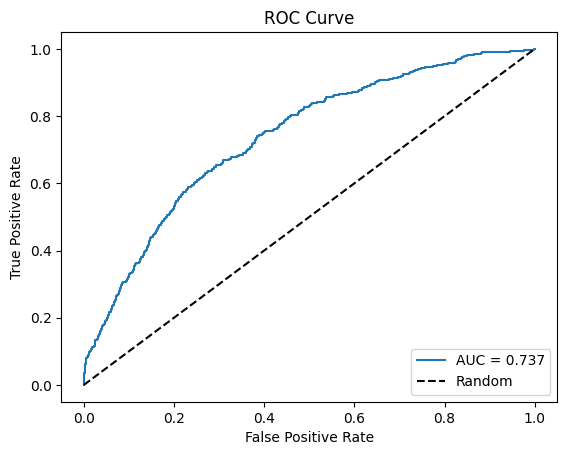

In [250]:
# Métrica AUC_ROC
auc = roc_auc_score(y_train, y_proba)

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_train, y_proba)
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

El area bajo la curva no es la bomba, pero tampoco podemos decir que sea mao del todo ya que es de 0.737. La curva se ve distanciada del modelo aleatorio auqnue es cierto que no se acerca demasiado al punto clave (1,0) donde la tasa de aciertos cuando es 0 es máxima y la tasa de fallos al ser 0 y el modelo clasificar como 1, es mínima.

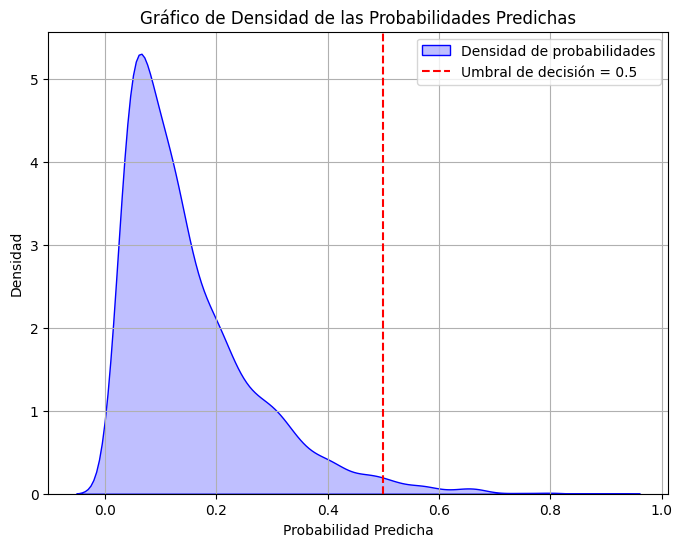

In [251]:
plt.figure(figsize=(8,6))
sns.kdeplot(y_proba, fill=True, color='blue', label='Densidad de probabilidades')
plt.title('Gráfico de Densidad de las Probabilidades Predichas')
plt.xlabel('Probabilidad Predicha')
plt.ylabel('Densidad')
plt.axvline(x =0.5, color='red', linestyle = '--', label='Umbral de decisión = 0.5')
plt.legend()
plt.grid(True)
plt.show()

Aqui lo que está pasando es que hemos entrenado este modelo de regresión logística con el conjunto original. Es decir, el conjunton que no está balanceado. En ese conjunto si recordamos, teníamos un volumen de 0s muy por encima del volumen de 1s. Y esta es la razón de las cosas raras que estamos viendo. La exactitud del modelo era buenísima, del 85% pero claro, la gran mayoría de nuestros datos son 0, y nuestro modelo se lo ha aprendido. Ha aprendido que si clasifica casi todo como 0, acierta en un porcentaje altisimo. Y eso es loq ue vemos en esta grñafca, que las probabilidades que está estimando el modelo, son casi todas 0 o muy cerca de 0. Con un umbral de 0.5, no vamos a clasificar como 1 a muy pocos valores. Este modelo no nos vale, porque cuando un registro que sea 1, diremos que es 0 casi seguro y fallaremos. Esto y nada es lo mismo a pesar de que haya métricas que nos estén intentando engañar como exactitiud o el recall del 0 (99%).

Ahora si , vamos a entrenar el modelo balanceado.

In [252]:
# Añadir una constante para el término independiente
X_train_balanced_const = sm.add_constant(X_train_balanced)

# Crear y ajustar el modelo
logit_model_balanced = sm.Logit(y_train_balanced, X_train_balanced_const).fit(maxiter=100)

# Resumen completo
print(logit_model_balanced.summary())

Optimization terminated successfully.
         Current function value: 0.579702
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:             TenYearCHD   No. Observations:                 5638
Model:                          Logit   Df Residuals:                     5622
Method:                           MLE   Df Model:                           15
Date:                Mon, 16 Jun 2025   Pseudo R-squ.:                  0.1637
Time:                        18:05:17   Log-Likelihood:                -3268.4
converged:                       True   LL-Null:                       -3908.0
Covariance Type:            nonrobust   LLR p-value:                1.561e-263
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.6696      0.074     -9.036      0.000      -0.815      -0.524
male          

Este modelo tiene un Psuedo-R2 algo mejor que el anterior siendo de 0.1637. Hay coeficientes que no son estadisticamente significativos, pero son menos que antes. 

In [253]:
# Lista de nombres de las columnas
variable_names = X_train_balanced.columns

# Incluimos la constante si está presente en los coeficientes
if 'const' in logit_model_balanced.params.index:
    variable_names = ['Intercepto'] + list(X_train_balanced.columns)
else: 
    variable_names = list(X_train_balanced.columns)

# Coeficientes del modelo 
coefficients = logit_model_balanced.params # Obtener los coeficientes 

# Crear un DataFrame para visualizar la relación variable-coeficiente 
coef_df = pd.DataFrame({'Variable':variable_names, 'Coeficiente': coefficients})

# Calcular los odss (e^coeficiente)
coef_df['Odds'] = np.exp(coef_df['Coeficiente'])

coef_df.sort_values(by='Coeficiente', ascending = False)

,Variable,Coeficiente,Odds
male,male,0.576440,1.779691
age,age,0.512258,1.669056
sysBP,sysBP,0.329939,1.390883
prevalentHyp,prevalentHyp,0.316904,1.372871
cigsPerDay,cigsPerDay,0.200721,1.222283
glucose,glucose,0.191350,1.210883
totChol,totChol,0.155523,1.168269
currentSmoker,currentSmoker,0.023131,1.023401
diaBP,diaBP,-0.013802,0.986293
heartRate,heartRate,-0.038131,0.962586


In [254]:
# Hacer predicciones (probabilidad de clase 1)
y_proba = logit_model_balanced.predict(X_train_balanced_const)

# Convertir las probabildiades en predicciones binarias
threshold = 0.5
y_pred = (y_proba >= threshold).astype(int)

# Construir la matriz de confiusión 
cm = confusion_matrix(y_train_balanced, y_pred)

# Evalaución del modelo 
print('Matriz de confusión:')
print(cm)

# Convertir la matriz de confusión a porcentajes
cm_percentage = cm.astype('float') / cm.sum() *100

# Imprimir la matriz en porcentajes con formato legible
print('Matriz de confusión en porcenajtes:')
print(np.round(cm_percentage, 2))

Matriz de confusión:
[[1920  899]
 [ 859 1960]]
Matriz de confusión en porcenajtes:
[[34.05 15.95]
 [15.24 34.76]]


Ahora ya si, la matriz de confusión se ve más normal. Es cierto que no son resultados muy buenos, pero está claro que son valores más normales acordes al Pseudo-R2 obtenido. Viendo los porcentajes de la matriz de confusión podemos decir que fallamos la mitad que acertamos. Pinta que vamos a tener un 0.66 de accuracy o similar.

In [255]:
print('n\Reporte de clasificación')
print(classification_report(y_train_balanced, y_pred))

n\Reporte de clasificación
              precision    recall  f1-score   support

           0       0.69      0.68      0.69      2819
           1       0.69      0.70      0.69      2819

    accuracy                           0.69      5638
   macro avg       0.69      0.69      0.69      5638
weighted avg       0.69      0.69      0.69      5638



<>:1: SyntaxWarning: invalid escape sequence '\R'
<>:1: SyntaxWarning: invalid escape sequence '\R'
C:\Users\pauri\AppData\Local\Temp\ipykernel_30532\626455199.py:1: SyntaxWarning: invalid escape sequence '\R'
  print('n\Reporte de clasificación')


Efectivamente, pintaba que la exactitiud estaría entorno al 0.66 y ha salido 0.69. Tiene una exactitud que no esta mal del todo. No es buena, pero tampoco para llorar. Las demás méttricas son similares y están bastante balanceadas. No paraece que haya ninguna de las 2 clases que tenga mejores méttricas o mayores fallos que la otra. Al estar balanceada la variable objetivo, vemos que el número de registros de cada tipo es el mismo exactamente. Esto gracias a los registros sintéticos que hemos incluido.


AUC-ROC: 0.7633405610159913


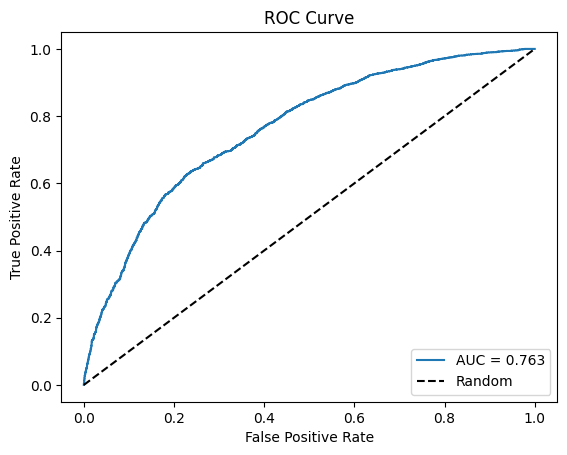

In [256]:
# Métrica AUC- ROC
auc = roc_auc_score ( y_train_balanced, y_proba)
print(f'\nAUC-ROC: {auc}')

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_train_balanced, y_proba)
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

La curva ROC ha mejorado ligeramente pero no mucho.

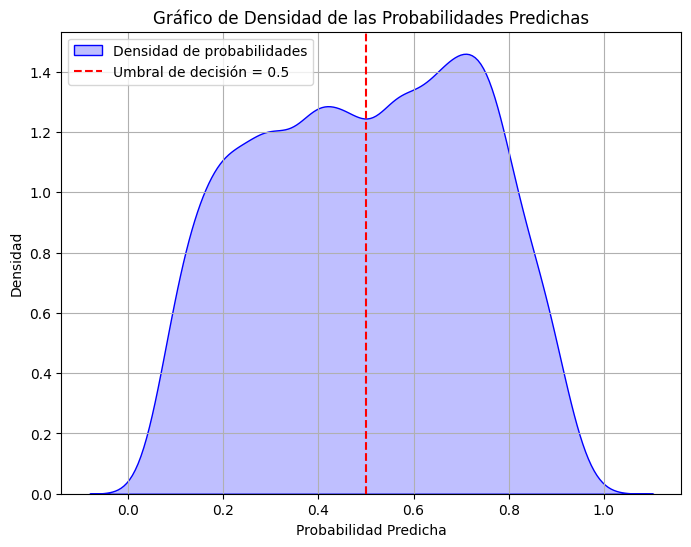

In [257]:
plt.figure(figsize=(8, 6))
sns.kdeplot(y_proba, fill=True, color="blue", label="Densidad de probabilidades")
plt.title('Gráfico de Densidad de las Probabilidades Predichas')
plt.xlabel('Probabilidad Predicha')
plt.ylabel('Densidad')
plt.axvline(x=0.5, color='red', linestyle='--', label="Umbral de decisión = 0.5")
plt.legend()
plt.grid(True)
plt.show()

Esta grafica de densidad tiene otra pinta. Ahora tenemos una curva simétrica donde a cada lado del 0.5 en este caso, tenemos más o menos el mismo número de registros. Es cierto que no están muy separados los 0s de los 1s, es decir, las probabilidades que estima el modelo no son muy claras. Se stiúan muy céntricas en la gráfica lo que hace que haya una cantidad de fallos alta.

Vamos ahora a tratar de verificar si generaliza o no el modelo en el conjunto de validación. En este caso no le pasamos los datos balanceados ni nada, simplemente le pasamos el conjunto de validación porque no estamos entrenando. Solo queremos ver que tal le va al modelo cuando le entren datos que no ha visto nunca. De esta forma vemos como generaliza. Da igual que todos los valores sean 0, lo importante es que sean valores nuevos.

In [258]:
# Añadir una constante para el término independiente 
X_test_const = sm.add_constant(X_test)

# Hacer predicciones (probabilidad de clase 1)
y_proba = logit_model_balanced.predict(X_test_const)

# Hacer las probabilidades en predicciones binarias
threshold = 0.5 
y_pred = (y_proba >= threshold).astype(int) 

# Construir las probabilidades en predicciones binarias
cm = confusion_matrix(y_test, y_pred)

# Evaluación del modelo
print('Matriz de confusión:')
print(cm)

# Convertir la matriz de confusión a porcentajes
cm_percentage = cm.astype('float') / cm.sum() * 100

# Imprimir la matriz en porcentajes con formato legible
print('Matriz de confusión porcentajes')
print(cm_percentage)

Matriz de confusión:
[[444 262]
 [ 50  76]]
Matriz de confusión porcentajes
[[53.36538462 31.49038462]
 [ 6.00961538  9.13461538]]


Parece que tenemos diferencias con respecto al modelo entrenado. Antes teníamos porcentajes de verdaderos positivios y negativos de en torno al 35% y ahora una ha subido al 53% y el otro al 9%. En cuanto a los errores, antes los teníamos ambos en aprox 14& y ahora los falsos negativos son 6% y los falsos positivos son el 31%.

In [259]:
print('\nReporte de clasificación:')
print(classification_report(y_test,y_pred))


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.90      0.63      0.74       706
           1       0.22      0.60      0.33       126

    accuracy                           0.62       832
   macro avg       0.56      0.62      0.53       832
weighted avg       0.80      0.62      0.68       832



Efectivamente, viendo las métricas, vemos que a nivel general tenemos una exactitud más baja que antes (ligeramente), de 0.69 hemos pasado a 0.62. Lo que más ha cambiado son las métrucas de precisión y f1-score. La precisión de clase 0, es decir de todo lo que el modelo dice que es 0, acertamos el 90%, mientras que cuando dice que es 1, acertamos solo el 22%. Casi siempre que dice 0 acierta, y casi siempre que dice 1 falla. Parece que aun habiendo balanceado el modelo, se ve que capturamos mejor el patrón del 0 que del 1. Esto puede ser porque a pesar de crear datos sintéticos, los datos de partida eran pocos y capturaban pocos patrones de calse 1, entonces nuestro modelo, no están bien ajustado a esta clase y falla casi siempre.

Sin emabrgo las sensibilidades están muy parejas. Esto es porque el umbral está separando bien ambas clases por la mitad de la gráfica, dejando la mitad de los registros a un lado y la otra mitad al otro. Para todo el conjunto de valores reales 0, nuestro modelo acierta el 63% de las veces. Y para los reales 1, acierta el 60% de las veces.


AUC-ROC: 0.680


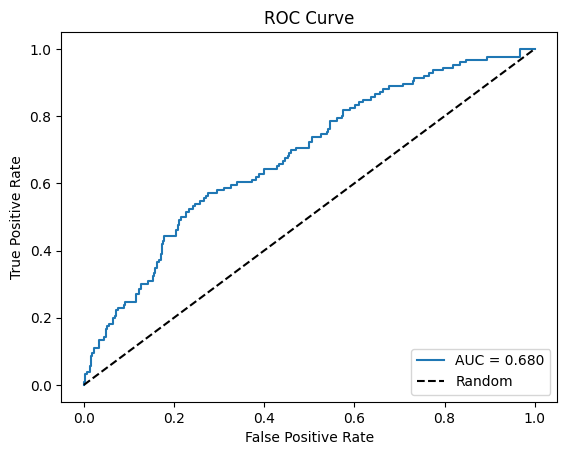

In [260]:
# Métrica AUC-ROC
auc = roc_auc_score(y_test, y_proba)
print(f"\nAUC-ROC: {auc:.3f}")

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

En este conjunto, hemos perdido algo de area bajo la curva y su forma es un tanto extraña pero sobre todo, está más pegada a la linea central del modelo aleatorio.

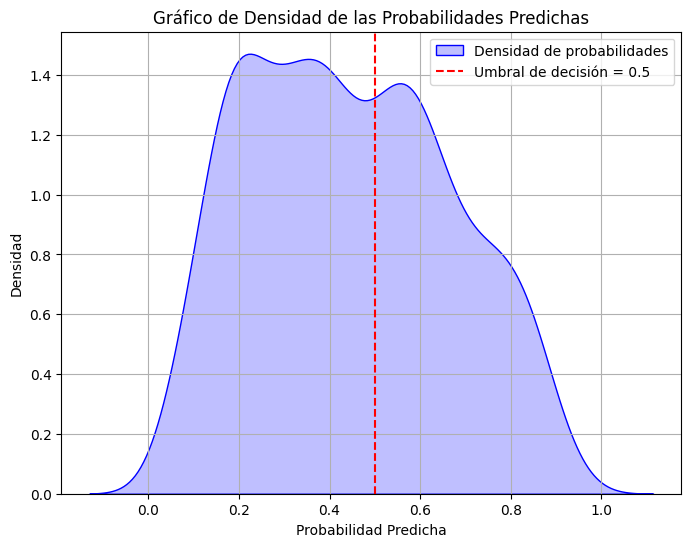

In [261]:
plt.figure(figsize=(8, 6))
sns.kdeplot(y_proba, fill=True, color="blue", label="Densidad de probabilidades")
plt.title('Gráfico de Densidad de las Probabilidades Predichas')
plt.xlabel('Probabilidad Predicha')
plt.ylabel('Densidad')
plt.axvline(x=0.5, color='red', linestyle='--', label="Umbral de decisión = 0.5")
plt.legend()
plt.grid(True)
plt.show()

#### 2. Selección de variables

Algunos mecanismos útiles que aportan cierta información relevante sobre cierta relación entre variables, nos pueden ser muy útiles a la hora de seleccionar o priorizar variables unas frente a otras. Siempre con la idea de reducir la dimensionalidad, mejorar la performance del modelo y evitar problemas de multicolinealidad o similar.

El primer mecanismo que vemos es el llamado VIF (Varianza Inflation Factor). Un indicaro que para cada variable nos da una idea de la multicolinealidad asociada a esta variable en un modelo de regresión. Basicamente nos va a ayudar a determinar que variables sobram de nuestro modelo porque están generando dependencia lineal y hace que los coeficientes no se calculen bien o directamente no se calculen por no ser invertible la matriz.

In [262]:
# Calculamos el VIF para cada variable
vif_data = pd.DataFrame()
vif_data['Variable'] = X_train_balanced_const.columns
vif_data['VIF'] = [variance_inflation_factor(X_train_balanced_const.values, i)
                   for i in range(X_train_balanced_const.shape[1])]

print(vif_data)


           Variable       VIF
0             const  5.886389
1              male  1.280770
2               age  1.431775
3         education  1.100658
4     currentSmoker  2.768821
5        cigsPerDay  2.917449
6            BPMeds  1.057621
7   prevalentStroke  1.014388
8      prevalentHyp  2.243752
9          diabetes  2.291359
10          totChol  1.080551
11            sysBP  4.122548
12            diaBP  3.222424
13              BMI  1.234027
14        heartRate  1.104068
15          glucose  2.350941


Si un coeficiente está por encima de 5 no es buena señal. Si está por encima de 10 es un problema grave. Por debajo de 5 está bien, es aceptable. El valor 1 es el ideal. Nuestros datos no presentan multicolinealidad. Esto ya lo sabíamos de antes puesto que nuestras correlaciones y V de Cramer mostraban que hay poca relación entre variables. Quizá la que más relación tenían entre si eran la <b>sysBP</b> y la <b>diaBP</B> y justo son las que tienen los valores más altos de VIF. Pero al estar por debajo de 5, la cosa está tranquila y no hay que alarmarse. 

Ahora vamos a aplicar un primer mecanismo de selección de variables. En este caso, el mecanismo será una selección hacia adelante (Forward). haremos uso de la métrica <b>accuracy</b> para que se tome como referencia para obtener el mejor número de variables, aquel que nos consiga el mejor valor de <b>accuracy</b>.

In [265]:
# Modelo Base
modelo = LogisticRegression()
score = 'accuracy'

# Selección hacia adelante
sfs = SFS(modelo,
            k_features = 'best',  # Número de características a seleccionar ('best' selecciona automáticamente) 
            forward= True,
            floating = True,
            scoring= score, # Métrica de evaluación: neg_log_loss, accuracy
            cv=5) # Validación cruzada

sfs.fit(X_train,y_train)

# Resultados 
print(f'Mejor {score}:', sfs.k_score_)
print('Número de variables seleccionadas: ', len(sfs.k_feature_names_))

# Variables seleccionadas
features_seleccionadas = list(sfs.k_feature_names_)

Mejor accuracy: 0.853489446507836
Número de variables seleccionadas:  11


De nuevo, haciendo uso del dataset desbalanceado, obtenemos una métrica de <b>accuracy</b> muy buena, 85%. El algoritmo de selección ha hecho su trabajo y ha seleccionado 11 variables y ha determinado que es la mejor combinación de variables. La que genera la mayor <b>accuracy</b> de todas las demás combinaciones.

In [266]:
# Modelo base 
modelo = LogisticRegression()

# Selección hace adelante 
sfs = SFS(modelo,
          k_features='best',  # Número de características a seleccionar ('best' selecciona automáticamente)
          forward=True,
          floating=False,
          scoring='accuracy',       # Métrica de evaluación: neg_log_loss, accuracy
          cv=5)               # Validación cruzada

sfs.fit(X_train_balanced, y_train_balanced)

# Resultados
print('Mejor Accuracy:', sfs.k_score_)
print('Número de variables seleccionadas: ', len(sfs.k_feature_names_))

# Variables seleccionadas
features_seleccionadas = list(sfs.k_feature_names_)

Mejor Accuracy: 0.6928096307903365
Número de variables seleccionadas:  5


Hacemos lo mismo con el conjunto balanceado y vemos como la cosa cambia. Es cierto que el algoritmo busca el <b>accuracy</b> más alto, pero este se consigue con un número de variables mucho menor: 5.

In [267]:
features_seleccionadas

['male', 'age', 'education', 'BPMeds', 'sysBP']

Tal como veiamos en el listado de variables por importancia relativa, las más importantes para esta variable objetivo parecen ser las mismas 5 que ha escogido el algoritmo de selección y el de importancia relativa.

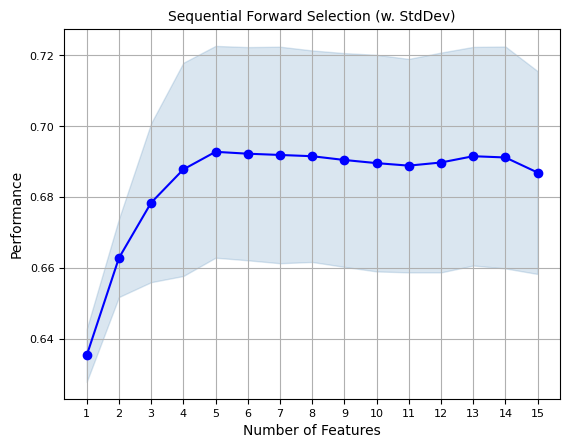

In [268]:
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

#plt.ylim([0.8, 1])
plt.title('Sequential Forward Selection (w. StdDev)', fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.grid()
plt.show()

Esta gráfica muestra la evolución del algoritmo hasta llegar a determinar las 5 variables elegidas. Al se hacía adelante, ha ido en cada iteración aumentando en una variable escogiendo siempre la que más aporta. Cuando ha llegado a 5, la siguiente iteración no ha habido forma de superar la anterior así que se ha quedado con valores más bajos.

Entrenamos por tanto un modelo de regresión logística con estas variables seleccionadas y vemos que tal se comporta.

In [269]:
#  Subconjunto de datos con las características seleccionadas
X_train_balanced_red = X_train_balanced[features_seleccionadas]

# Añadir constante (intercepto)
X_train_balanced_red = sm.add_constant(X_train_balanced_red)

# Crear y ajustar el modelo
logit_model_balanced_fwd = sm.Logit(y_train_balanced, X_train_balanced_red).fit(maxiter=100)

# Resumen del modelo
print(logit_model_balanced_fwd.summary())

Optimization terminated successfully.
         Current function value: 0.588253
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:             TenYearCHD   No. Observations:                 5638
Model:                          Logit   Df Residuals:                     5632
Method:                           MLE   Df Model:                            5
Date:                Mon, 16 Jun 2025   Pseudo R-squ.:                  0.1513
Time:                        18:05:54   Log-Likelihood:                -3316.6
converged:                       True   LL-Null:                       -3908.0
Covariance Type:            nonrobust   LLR p-value:                1.573e-253
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5999      0.044    -13.623      0.000      -0.686      -0.514
male           0.6849      0.

Parece ligeramente peor que el último entrenado con toas las variables por tener un Pseud-R2 de 0.157 en vez de 0.16. Pero la diferencia es poca y sin embargi hemos reducido el conjunto en 10 variables. Es una mejora grande en dimensionalidad.

In [270]:
# Hacer predicciones (probabilidad de clase 1)
y_proba = logit_model_balanced_fwd.predict(X_train_balanced_red)

# Convertir las probabilidades en predicciones binarias
threshold = 0.5
y_pred = (y_proba >= threshold).astype(int)

# Construir la matriz de confusión
cm = confusion_matrix(y_train_balanced, y_pred)

# Evaluación del modelo
print("Matriz de confusión:")
print(cm)

# Convertir la matriz de confusión a porcentajes
cm_percentage = cm.astype('float') / cm.sum() * 100

# Imprimir la matriz en porcentajes con formato legible
print("Matriz de confusión en porcentajes:")
print(np.round(cm_percentage, 2))


Matriz de confusión:
[[1926  893]
 [ 834 1985]]
Matriz de confusión en porcentajes:
[[34.16 15.84]
 [14.79 35.21]]


In [271]:
print("\nReporte de clasificación:")
print(classification_report(y_train_balanced, y_pred))


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.70      0.68      0.69      2819
           1       0.69      0.70      0.70      2819

    accuracy                           0.69      5638
   macro avg       0.69      0.69      0.69      5638
weighted avg       0.69      0.69      0.69      5638




AUC-ROC: 0.755


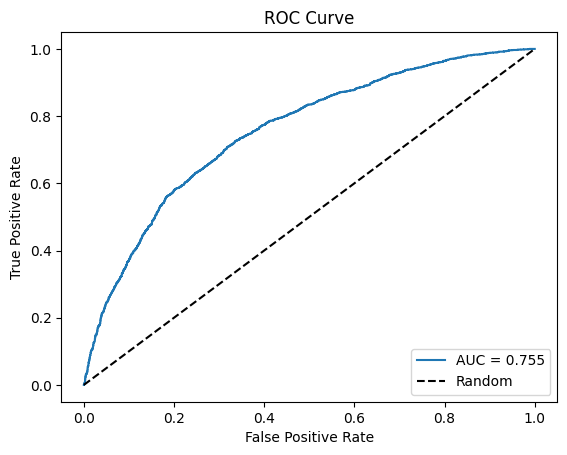

In [272]:
# Métrica AUC-ROC
auc = roc_auc_score(y_train_balanced, y_proba)
print(f"\nAUC-ROC: {auc:.3f}")

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_train_balanced, y_proba)
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

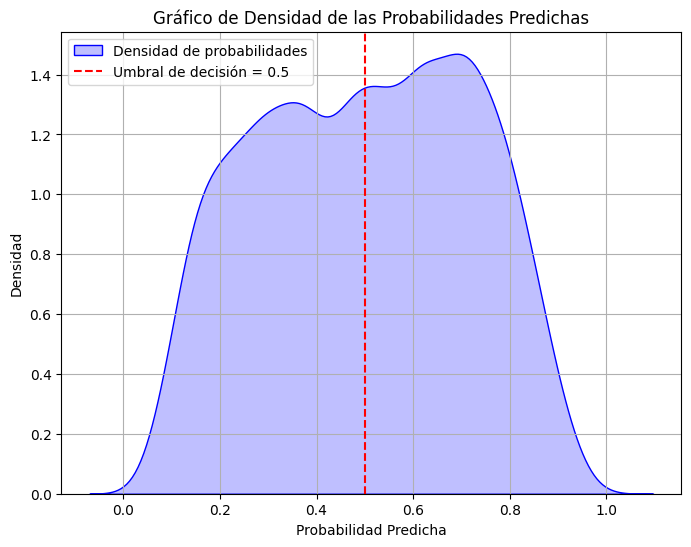

In [273]:
plt.figure(figsize=(8, 6))
sns.kdeplot(y_proba, fill=True, color="blue", label="Densidad de probabilidades")
plt.title('Gráfico de Densidad de las Probabilidades Predichas')
plt.xlabel('Probabilidad Predicha')
plt.ylabel('Densidad')
plt.axvline(x=0.5, color='red', linestyle='--', label="Umbral de decisión = 0.5")
plt.legend()
plt.grid(True)
plt.show()

Vamos ahora a probar el mismo método de selección pero cambiando la métrica. Esta vez trataremos de mejorar la <b>precisió</b> al máximo.

In [274]:
# Modelo base
modelo = LogisticRegression()
score = 'precision' #neg_log_loss, accuracy, recall, roc_auc, precision

# Selección hacia adelante
sfs = SFS(modelo,
          k_features='best',  # Número de características a seleccionar ('best' selecciona automáticamente)
          forward=True,
          floating=False,
          scoring=score,       # Métrica de evaluación
          cv=5)               # Validación cruzada

sfs.fit(X_train_balanced, y_train_balanced)

# Resultados
print(f'Mejor {score}:', sfs.k_score_)
print('Número de variables seleccionadas: ', len(sfs.k_feature_names_))

# Variables seleccionadas
features_seleccionadas = list(sfs.k_feature_names_)

Mejor precision: 0.689521930401318
Número de variables seleccionadas:  14


In [275]:
features_seleccionadas

['male',
 'age',
 'education',
 'currentSmoker',
 'BPMeds',
 'prevalentStroke',
 'prevalentHyp',
 'diabetes',
 'totChol',
 'sysBP',
 'diaBP',
 'BMI',
 'heartRate',
 'glucose']

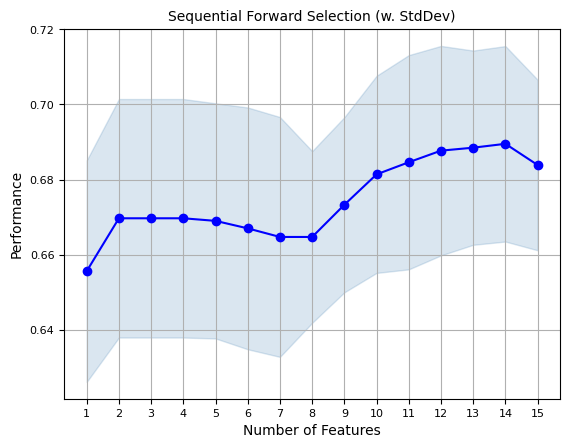

In [276]:
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

#plt.ylim([0.8, 1])
plt.title('Sequential Forward Selection (w. StdDev)', fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.grid()
plt.show()

In [277]:
# Subconjunto de datos con las características seleccionadas
X_train_balanced_red = X_train_balanced[features_seleccionadas]

# Añadir constante (intercepto)
X_train_balanced_red = sm.add_constant(X_train_balanced_red)

# Crear y ajustar el modelo
logit_model_balanced_fwd_2 = sm.Logit(y_train_balanced, X_train_balanced_red).fit(maxiter=100)

# Resumen del modelo
print(logit_model_balanced_fwd_2.summary())

Optimization terminated successfully.
         Current function value: 0.581015
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:             TenYearCHD   No. Observations:                 5638
Model:                          Logit   Df Residuals:                     5623
Method:                           MLE   Df Model:                           14
Date:                Mon, 16 Jun 2025   Pseudo R-squ.:                  0.1618
Time:                        18:06:02   Log-Likelihood:                -3275.8
converged:                       True   LL-Null:                       -3908.0
Covariance Type:            nonrobust   LLR p-value:                2.460e-261
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.8367      0.060    -13.889      0.000      -0.955      -0.719
male          

Este modelo es ligeramente mejor que el anterior en cuanto a Pseudo-R2, pero el número de variables es casi el mismo que el original. Solo le hemos quitado 1.

In [278]:
# Hacer predicciones (probabilidad de clase 1)
y_proba = logit_model_balanced_fwd_2.predict(X_train_balanced_red)

# Convertir las probabilidades en predicciones binarias
threshold = 0.5
y_pred = (y_proba >= threshold).astype(int)

# Construir la matriz de confusión
cm = confusion_matrix(y_train_balanced, y_pred)

# Evaluación del modelo
print("Matriz de confusión:")
print(cm)

# Convertir la matriz de confusión a porcentajes
cm_percentage = cm.astype('float') / cm.sum() * 100

# Imprimir la matriz en porcentajes con formato legible
print("Matriz de confusión en porcentajes:")
print(np.round(cm_percentage, 2))

Matriz de confusión:
[[1932  887]
 [ 854 1965]]
Matriz de confusión en porcentajes:
[[34.27 15.73]
 [15.15 34.85]]


In [279]:
print("\nReporte de clasificación:")
print(classification_report(y_train_balanced, y_pred))


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.69      0.69      0.69      2819
           1       0.69      0.70      0.69      2819

    accuracy                           0.69      5638
   macro avg       0.69      0.69      0.69      5638
weighted avg       0.69      0.69      0.69      5638



Efectivament se maximiza la precisión y las métricas en general son bastante parejas y están balanceadas.


AUC-ROC: 0.762


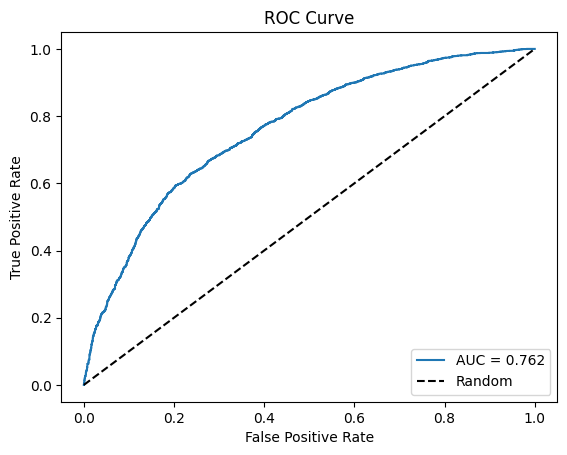

In [280]:
# Métrica AUC-ROC
auc = roc_auc_score(y_train_balanced, y_proba)
print(f"\nAUC-ROC: {auc:.3f}")

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_train_balanced, y_proba)
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

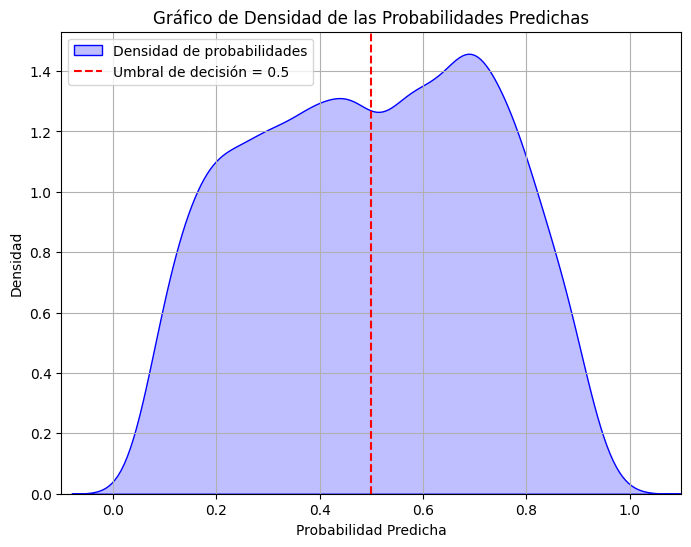

In [281]:
plt.figure(figsize=(8, 6))
sns.kdeplot(y_proba, fill=True, color="blue", label="Densidad de probabilidades")
plt.title('Gráfico de Densidad de las Probabilidades Predichas')
plt.xlabel('Probabilidad Predicha')
plt.ylabel('Densidad')
plt.axvline(x=0.5, color='red', linestyle='--', label="Umbral de decisión = 0.5")
plt.legend()
plt.grid(True)
plt.xlim(-0.1,1.1)
plt.show()

Vamos ahora a utilizar el método de selección de variables backward. Es decir, aquel que parte d todas y va eliminando. En primer lugar, vamos a implementar una versión de éste que va eliminando aquellas variables con mayor p-value que hace que no sea significativo el coeficiente. Cuando ya no queden coeficientes no significativos, para y se queda con esas variables.

In [282]:
def backward_selectio_pvalues ( X, y, significance_level = 0.05):
    # Agregar una columna de constantes (intercepto)
    X = add_constant(X)
    selected_features = list(X.columns)

    while len(selected_features) > 1:
        # Ajustar el modelo logístico
        model = Logit(y, X[selected_features]).fit(disp=False)

        # Obtener p-values
        pvalues = model.pvalues

        # Eliminar la característica con el p-value más alto si está por encima del nivel de significancia 
        max_pvalue = pvalues.max()
        if max_pvalue > significance_level:
            feature_to_remove = pvalues.idxmax()
            selected_features.remove(feature_to_remove)
            print(f'Eliminando {feature_to_remove} con p-value {max_pvalue: .4f}')
        else: 
            break # Salir si todos los p-values están por debajo del nivel de significancia 

    # Devolver la lista de características seleccionadas (sin la constante)
    selected_features.remove('const')
    return selected_features

# Ejemplo de uso
# X es un DataFrame con características, y es una serie con la variable dependiente
features_seleccionadas = backward_selectio_pvalues(X_train_balanced, y_train_balanced, significance_level=0.05)
print("\nNumero de variables seleccionadas:", len(features_seleccionadas))
print("Variables seleccionadas:", features_seleccionadas)

Eliminando currentSmoker con p-value  0.8183
Eliminando prevalentStroke con p-value  0.8120
Eliminando diaBP con p-value  0.7900
Eliminando heartRate con p-value  0.2422

Numero de variables seleccionadas: 11
Variables seleccionadas: ['male', 'age', 'education', 'cigsPerDay', 'BPMeds', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP', 'BMI', 'glucose']


Parece que el algoritmo ha eliminado 4 variables con unos p-values alto y se ha quedado con las 11 restantes.  Es una forma de hacer esta selección de variables. Podemos entrenar el modelo y ver que resultados genera:

In [283]:
# Subconjunto de datos con las características seleccionadas
X_train_balanced_red = X_train_balanced[features_seleccionadas]

# Añadir constante (intercepto)
X_train_balanced_red = sm.add_constant(X_train_balanced_red)

# Crear y ajustar el modelo
logit_model_balanced_bwd = sm.Logit(y_train_balanced, X_train_balanced_red).fit(maxiter=100)

# Resumen del modelo
print(logit_model_balanced_bwd.summary())

Optimization terminated successfully.
         Current function value: 0.579839
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:             TenYearCHD   No. Observations:                 5638
Model:                          Logit   Df Residuals:                     5626
Method:                           MLE   Df Model:                           11
Date:                Mon, 16 Jun 2025   Pseudo R-squ.:                  0.1635
Time:                        18:06:03   Log-Likelihood:                -3269.1
converged:                       True   LL-Null:                       -3908.0
Covariance Type:            nonrobust   LLR p-value:                2.933e-267
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.6581      0.054    -12.256      0.000      -0.763      -0.553
male             0.5827

Parece que con esats 11 variables hemos escogido con mejor Pseudo-R2 hasta ahora. Todos los coeficientes, como era de esperar, son significativos.

In [284]:
# Hacer predicciones (probabilidad de clase 1)
y_proba = logit_model_balanced_bwd.predict(X_train_balanced_red)

# Convertir las probabilidades en predicciones binarias
threshold = 0.5
y_pred = (y_proba >= threshold).astype(int)

# Construir la matriz de confusión
cm = confusion_matrix(y_train_balanced, y_pred)

# Evaluación del modelo
print("Matriz de confusión:")
print(cm)

# Convertir la matriz de confusión a porcentajes
cm_percentage = cm.astype('float') / cm.sum() * 100

# Imprimir la matriz en porcentajes con formato legible
print("Matriz de confusión en porcentajes:")
print(np.round(cm_percentage, 2))

Matriz de confusión:
[[1922  897]
 [ 853 1966]]
Matriz de confusión en porcentajes:
[[34.09 15.91]
 [15.13 34.87]]


In [285]:
print("\nReporte de clasificación:")
print(classification_report(y_train_balanced, y_pred))


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.69      0.68      0.69      2819
           1       0.69      0.70      0.69      2819

    accuracy                           0.69      5638
   macro avg       0.69      0.69      0.69      5638
weighted avg       0.69      0.69      0.69      5638



Las métricas son muy similares a las anteriores.


AUC-ROC: 0.763


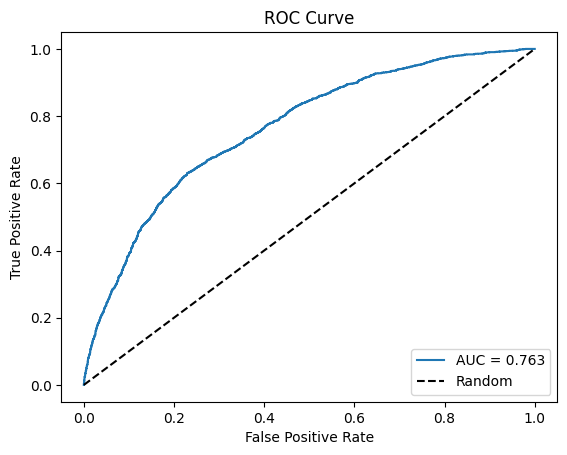

In [286]:
# Métrica AUC-ROC
auc = roc_auc_score(y_train_balanced, y_proba)
print(f"\nAUC-ROC: {auc:.3f}")

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_train_balanced, y_proba)
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

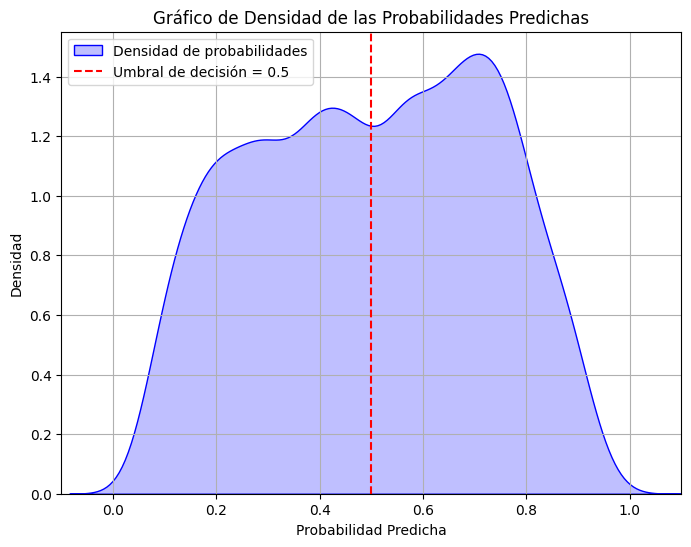

In [287]:
plt.figure(figsize=(8, 6))
sns.kdeplot(y_proba, fill=True, color="blue", label="Densidad de probabilidades")
plt.title('Gráfico de Densidad de las Probabilidades Predichas')
plt.xlabel('Probabilidad Predicha')
plt.ylabel('Densidad')
plt.axvline(x=0.5, color='red', linestyle='--', label="Umbral de decisión = 0.5")
plt.legend()
plt.grid(True)
plt.xlim(-0.1,1.1)
plt.show()

Ahora procedemos a realizar una selección hacia atrás (backward), pero esta vez en lugar de basarnos en el p-value, vamos a hacerlo en base a una métrica (accuracy). De esta forma, el algoritmo eimina en función de esta métrica buscando que no baje o, como en este caso, quedandonos con la combinación de variables que maximiza esa métrica.

In [288]:
# Modelo base
modelo = LogisticRegression()
score = 'accuracy' #neg_log_loss, accuracy, recall, roc_auc, precision

# Selección hacia adelante
sbs = SFS(modelo,
          k_features='best',  # Número de características a seleccionar ('best' selecciona automáticamente)
          forward=False,
          floating=False,
          scoring=score,       # Métrica de evaluación
          cv=5)               # Validación cruzada

sbs.fit(X_train_balanced, y_train_balanced)

# Resultados
print(f'Mejor {score}:', sbs.k_score_)
print('Número de variables seleccionadas: ', len(sbs.k_feature_names_))

# Variables seleccionadas
features_seleccionadas = list(sbs.k_feature_names_)

Mejor accuracy: 0.6938740898764687
Número de variables seleccionadas:  11


In [289]:
features_seleccionadas

['male',
 'age',
 'education',
 'currentSmoker',
 'BPMeds',
 'prevalentHyp',
 'diabetes',
 'totChol',
 'sysBP',
 'heartRate',
 'glucose']

Viendo la métrica de <b>accuracy</b> alcanzada y las variables seleccionadas, vemos que es casi igual que el último modelo que tenía casi las mismas variables y conseguí una exactitud muy similar.

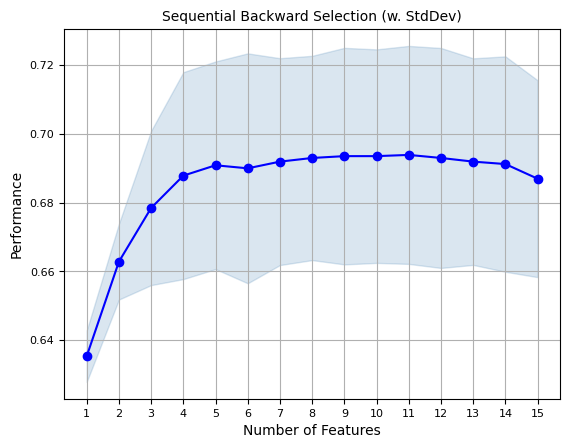

In [290]:
fig1 = plot_sfs(sbs.get_metric_dict(), kind='std_dev')

#plt.ylim([0.8, 1])
plt.title('Sequential Backward Selection (w. StdDev)', fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.grid()
plt.show()

In [291]:
# Subconjunto de datos con las características seleccionadas
X_train_balanced_red = X_train_balanced[features_seleccionadas]

# Añadir constante (intercepto)
X_train_balanced_red = sm.add_constant(X_train_balanced_red)

# Crear y ajustar el modelo
logit_model_balanced_bwd = sm.Logit(y_train_balanced, X_train_balanced_red).fit(maxiter=100)

# Resumen del modelo
print(logit_model_balanced_bwd.summary())

Optimization terminated successfully.
         Current function value: 0.581480
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:             TenYearCHD   No. Observations:                 5638
Model:                          Logit   Df Residuals:                     5626
Method:                           MLE   Df Model:                           11
Date:                Mon, 16 Jun 2025   Pseudo R-squ.:                  0.1611
Time:                        18:06:13   Log-Likelihood:                -3278.4
converged:                       True   LL-Null:                       -3908.0
Covariance Type:            nonrobust   LLR p-value:                2.871e-263
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.8303      0.060    -13.857      0.000      -0.948      -0.713
male              0.

In [292]:
# Hacer predicciones (probabilidad de clase 1)
y_proba = logit_model_balanced_bwd.predict(X_train_balanced_red)

# Convertir las probabilidades en predicciones binarias
threshold = 0.5
y_pred = (y_proba >= threshold).astype(int)

# Construir la matriz de confusión
cm = confusion_matrix(y_train_balanced, y_pred)

# Evaluación del modelo
print("Matriz de confusión:")
print(cm)

# Convertir la matriz de confusión a porcentajes
cm_percentage = cm.astype('float') / cm.sum() * 100

# Imprimir la matriz en porcentajes con formato legible
print("Matriz de confusión en porcentajes:")
print(np.round(cm_percentage, 2))

Matriz de confusión:
[[1922  897]
 [ 837 1982]]
Matriz de confusión en porcentajes:
[[34.09 15.91]
 [14.85 35.15]]


In [293]:
print("\nReporte de clasificación:")
print(classification_report(y_train_balanced, y_pred))


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.70      0.68      0.69      2819
           1       0.69      0.70      0.70      2819

    accuracy                           0.69      5638
   macro avg       0.69      0.69      0.69      5638
weighted avg       0.69      0.69      0.69      5638




AUC-ROC: 0.762


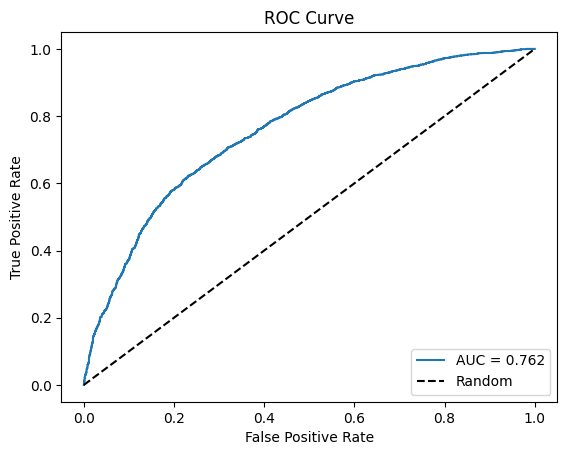

In [294]:
# Métrica AUC-ROC
auc = roc_auc_score(y_train_balanced, y_proba)
print(f"\nAUC-ROC: {auc:.3f}")

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_train_balanced, y_proba)
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

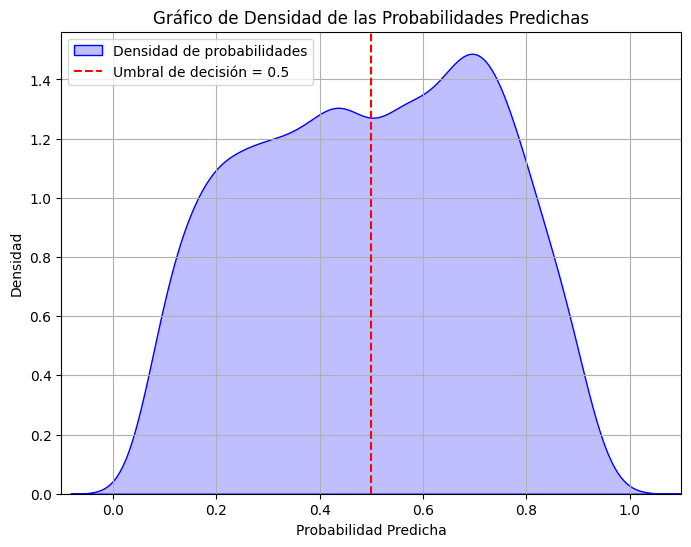

In [295]:
plt.figure(figsize=(8, 6))
sns.kdeplot(y_proba, fill=True, color="blue", label="Densidad de probabilidades")
plt.title('Gráfico de Densidad de las Probabilidades Predichas')
plt.xlabel('Probabilidad Predicha')
plt.ylabel('Densidad')
plt.axvline(x=0.5, color='red', linestyle='--', label="Umbral de decisión = 0.5")
plt.legend()
plt.grid(True)
plt.xlim(-0.1,1.1)
plt.show()

Ejecutamos ahora la selección de variables con este mismo método hacia atras, pero esta vez estableceremos el númeo de variables escogidas como el que menos variables dentro de una desviación estandar respecto del numero de variables con la mayor métrica de precisión.

In [296]:
# Modelo base
modelo = LogisticRegression()
score = 'precision' #neg_log_loss, accuracy, recall, roc_auc, precision

# Selección hacia adelante
sbs = SFS(modelo,
          k_features='parsimonious',  # Número de características a seleccionar ('best' selecciona automáticamente)
          forward=False,
          floating=False,
          scoring=score,       # Métrica de evaluación
          cv=5)               # Validación cruzada

sbs.fit(X_train_balanced, y_train_balanced)

# Resultados
print(f'Mejor {score}:', sbs.k_score_)
print('Número de variables seleccionadas: ', len(sbs.k_feature_names_))

# Variables seleccionadas
features_seleccionadas = list(sbs.k_feature_names_)

Mejor precision: 0.6904595676074201
Número de variables seleccionadas:  5


In [297]:
features_seleccionadas

['male', 'age', 'education', 'BPMeds', 'sysBP']

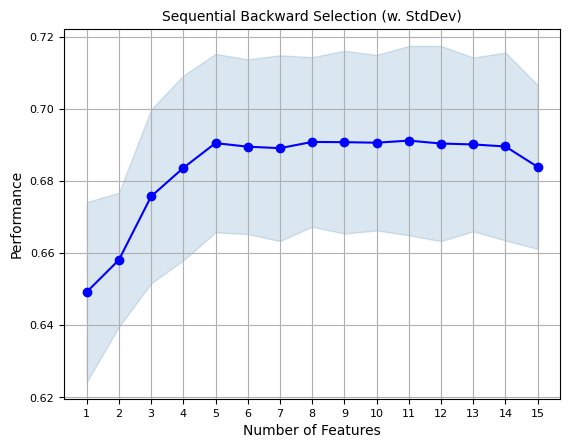

In [298]:
fig1 = plot_sfs(sbs.get_metric_dict(), kind='std_dev')

#plt.ylim([0.8, 1])
plt.title('Sequential Backward Selection (w. StdDev)', fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.grid()
plt.show()

Esta vez se han seleccionado 5 variables. Es cierto que el valor más alto se alcanza en 11 variables, pero como el 5 es el menor de todos aquellos que tienen una métrica muy cercana a la del 11, se ha decidido quedar con la de 5 variables.

In [299]:
# Subconjunto de datos con las características seleccionadas
X_train_balanced_red = X_train_balanced[features_seleccionadas]

# Añadir constante (intercepto)
X_train_balanced_red = sm.add_constant(X_train_balanced_red)

# Crear y ajustar el modelo
logit_model_balanced_bwd = sm.Logit(y_train_balanced, X_train_balanced_red).fit(maxiter=100)

# Resumen del modelo
print(logit_model_balanced_bwd.summary())

Optimization terminated successfully.
         Current function value: 0.588253
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:             TenYearCHD   No. Observations:                 5638
Model:                          Logit   Df Residuals:                     5632
Method:                           MLE   Df Model:                            5
Date:                Mon, 16 Jun 2025   Pseudo R-squ.:                  0.1513
Time:                        18:06:26   Log-Likelihood:                -3316.6
converged:                       True   LL-Null:                       -3908.0
Covariance Type:            nonrobust   LLR p-value:                1.573e-253
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5999      0.044    -13.623      0.000      -0.686      -0.514
male           0.6849      0.

In [300]:
# Hacer predicciones (probabilidad de clase 1)
y_proba = logit_model_balanced_bwd.predict(X_train_balanced_red)

# Convertir las probabilidades en predicciones binarias
threshold = 0.5
y_pred = (y_proba >= threshold).astype(int)

# Construir la matriz de confusión
cm = confusion_matrix(y_train_balanced, y_pred)

# Evaluación del modelo
print("Matriz de confusión:")
print(cm)

# Convertir la matriz de confusión a porcentajes
cm_percentage = cm.astype('float') / cm.sum() * 100

# Imprimir la matriz en porcentajes con formato legible
print("Matriz de confusión en porcentajes:")
print(np.round(cm_percentage, 2))

Matriz de confusión:
[[1926  893]
 [ 834 1985]]
Matriz de confusión en porcentajes:
[[34.16 15.84]
 [14.79 35.21]]


In [301]:
print("\nReporte de clasificación:")
print(classification_report(y_train_balanced, y_pred))


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.70      0.68      0.69      2819
           1       0.69      0.70      0.70      2819

    accuracy                           0.69      5638
   macro avg       0.69      0.69      0.69      5638
weighted avg       0.69      0.69      0.69      5638




AUC-ROC: 0.755


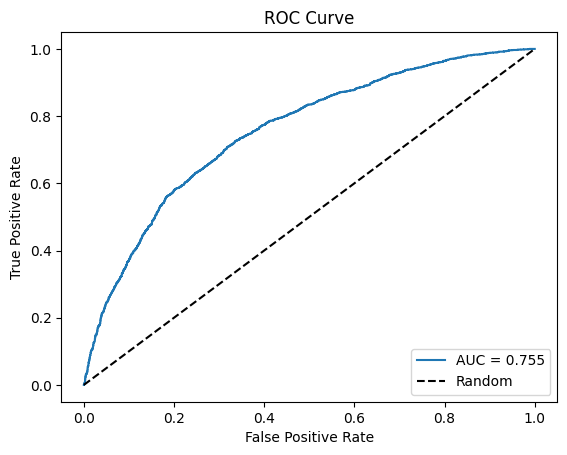

In [302]:
# Métrica AUC-ROC
auc = roc_auc_score(y_train_balanced, y_proba)
print(f"\nAUC-ROC: {auc:.3f}")

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_train_balanced, y_proba)
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

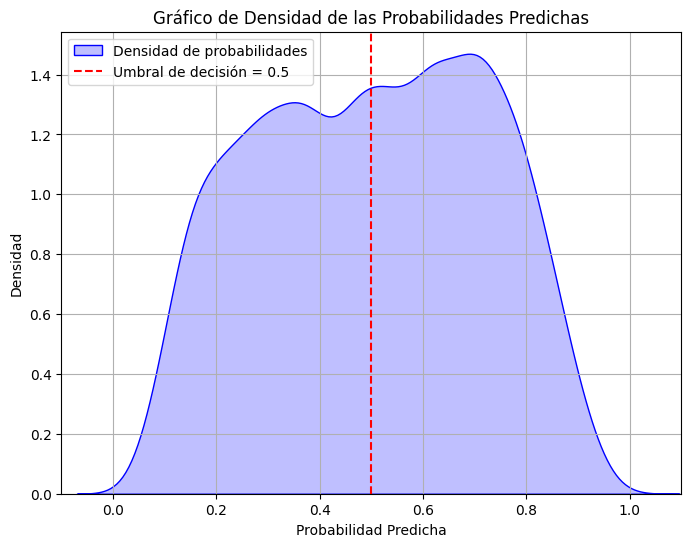

In [303]:
plt.figure(figsize=(8, 6))
sns.kdeplot(y_proba, fill=True, color="blue", label="Densidad de probabilidades")
plt.title('Gráfico de Densidad de las Probabilidades Predichas')
plt.xlabel('Probabilidad Predicha')
plt.ylabel('Densidad')
plt.axvline(x=0.5, color='red', linestyle='--', label="Umbral de decisión = 0.5")
plt.legend()
plt.grid(True)
plt.xlim(-0.1,1.1)
plt.show()

Ahora vamos a aplicar un método de regularización que nos haga durante el entrenamiento del modelo una selección de variables al convertir en 0 aquellos coeficientes que estime oportunos. Empezamos con regularización de nivel 1 LASSO con función liblinear y coeficiente de regularización de 1. Como la regularización LASSO no se puede aplicar directamente en los modelos de regresión de StatsModelo, vamos a realizarlos con los de sklearn y sacaremos las métricas de una forma más manual pero que nos srive para entender los resultados.

In [304]:
# Crear el modelo de regresión logística con regularización LASSO
lasso_model_balanced = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, random_state=42)

# Ajustar el modelo a los datos de entrenamiento
lasso_model_balanced.fit(X_train_balanced, y_train_balanced)

# Predicciones en el conjunto de entrenamiento
y_pred = lasso_model_balanced.predict(X_train_balanced)
y_proba = lasso_model_balanced.predict_proba(X_train_balanced)[:, 1]

# Evaluar el modelo
accuracy = accuracy_score(y_train_balanced, y_pred)
roc_auc = roc_auc_score(y_train_balanced, y_proba)

print("Accuracy:", accuracy)
print("ROC AUC:", roc_auc)
print("Clasificación:\n", classification_report(y_train_balanced, y_pred))

Accuracy: 0.6880099326002128
ROC AUC: 0.7633014255745203
Clasificación:
               precision    recall  f1-score   support

           0       0.69      0.68      0.69      2819
           1       0.68      0.70      0.69      2819

    accuracy                           0.69      5638
   macro avg       0.69      0.69      0.69      5638
weighted avg       0.69      0.69      0.69      5638



In [305]:
# Lista de nombres de las columnas
variable_names = X_train_balanced.columns

# Coeficientes del modelo
coefficients = lasso_model_balanced.coef_[0]  # Obtener los coeficientes como un array (dimensión 0 por ser un modelo binario)

# Crear un DataFrame para visualizar la relación variable-coeficiente
coef_df = pd.DataFrame({'Variable': variable_names,'Coeficiente': coefficients})

# Calcular los odds (e^coeficiente)
coef_df['Odds'] = np.exp(coef_df['Coeficiente'])

coef_df.sort_values(by='Coeficiente', ascending=False)

,Variable,Coeficiente,Odds
0,male,0.569396,1.767199
1,age,0.511574,1.667914
10,sysBP,0.326372,1.385931
7,prevalentHyp,0.305002,1.356627
4,cigsPerDay,0.205186,1.227754
14,glucose,0.182042,1.199665
9,totChol,0.154054,1.166554
3,currentSmoker,0.011074,1.011135
6,prevalentStroke,0.000000,1.000000
11,diaBP,-0.008019,0.992013


Más allá de las métricas, que no son en general demasiado malas y van un poco en la misma línea que los demás modelos que hemos ido viendo con anteriores métodos de selección, lo más interesante es ver e interpretar los coeficientes y los odds ratios. Con un factor de regularización 1, para un solver de tipo liblinear, nuestro modelo ha regularizaco algunos coeficientes reduciendolos para quitarles peso en la regresión y aligerarla. Es dificil sin comparar, ver cuales ha regularizado y cuales no. Para ello tendríamos que entrenar la misma regresión pero confactor de regularización igual a 0 y comparar los coeficientes con estos que hemos obtenido para ver las diferencias. Seguramente haya reducido el valor de aquellos que ha considerado menos relevantes. En concreto, el coeficiente associado a la variable <b>prevalentStroke</b>, lo ha reducido tanto, que lo ha convertido en cero a pesar de que este método a priori no elimina variables. Debe ser muy bestia el poco aporte que hace esta variable. Es normal puesto que había muy pocos registros con valor 1, es casi una variable constante.

Vamos a probar a modificar el factor de regularización a través del parametro C de la función. La vamos a configurar en 0.01 que sería el equivalente a poner un valor de lambda muy elevado, es decir, que regularice bien.

In [306]:
# Crear el modelo de regresión logística con regularización LASSO
lasso_model_balanced = LogisticRegression(penalty='l1', solver='liblinear', C=0.01, random_state=42)

# Ajustar el modelo a los datos de entrenamiento
lasso_model_balanced.fit(X_train_balanced, y_train_balanced)

# Predicciones en el conjunto de entrenamiento
y_pred = lasso_model_balanced.predict(X_train_balanced)
y_proba = lasso_model_balanced.predict_proba(X_train_balanced)[:, 1]

# Evaluar el modelo
accuracy = accuracy_score(y_train_balanced, y_pred)
roc_auc = roc_auc_score(y_train_balanced, y_proba)

print("Accuracy:", accuracy)
print("ROC AUC:", roc_auc)
print("Clasificación:\n", classification_report(y_train_balanced, y_pred))

Accuracy: 0.6819794253281305
ROC AUC: 0.7499085476460158
Clasificación:
               precision    recall  f1-score   support

           0       0.70      0.64      0.67      2819
           1       0.67      0.72      0.70      2819

    accuracy                           0.68      5638
   macro avg       0.68      0.68      0.68      5638
weighted avg       0.68      0.68      0.68      5638



In [307]:
# Lista de nombres de las columnas
variable_names = X_train_balanced.columns

# Coeficientes del modelo
coefficients = lasso_model_balanced.coef_[0]  # Obtener los coeficientes como un array (dimensión 0 por ser un modelo binario)

# Crear un DataFrame para visualizar la relación variable-coeficiente
coef_df = pd.DataFrame({'Variable': variable_names,'Coeficiente': coefficients})

# Calcular los odds (e^coeficiente)
coef_df['Odds'] = np.exp(coef_df['Coeficiente'])

coef_df.sort_values(by='Coeficiente', ascending=False)

,Variable,Coeficiente,Odds
1,age,0.433821,1.543143
10,sysBP,0.314867,1.370077
4,cigsPerDay,0.176625,1.193184
0,male,0.059563,1.061373
14,glucose,0.039458,1.040247
9,totChol,0.035550,1.036190
5,BPMeds,0.000000,1.000000
7,prevalentHyp,0.000000,1.000000
6,prevalentStroke,0.000000,1.000000
3,currentSmoker,0.000000,1.000000


A la vista de los resultados podemos ver que efectivamente el aumentar el factor de regularización, ahora tenemos muchas variables que el algoritmo ha reducido el valor de su coeficiente a 0 prácticamente y las interpreta como tal. Esta reduciendo las menos relevantes quedandose con las más interesantes para el modelo, y se ve que los valores de la regresión, las métricas, no cambian mucho.

En este ejemplo vamos a crear un grid con un conjunto de posibles valores del parametro C de regularización para que nos diga con cual de ellos se consigue la mejor me´trica de accuracy.

In [308]:
from sklearn.model_selection import GridSearchCV

# Definir los valores de C a probar
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

grid_search = GridSearchCV(
    LogisticRegression(penalty='l1', solver='liblinear', random_state=42),
    param_grid,
    scoring='accuracy',
    cv=5
)

grid_search.fit(X_train_balanced, y_train_balanced)

print("Mejor valor de C:", grid_search.best_params_['C'])
print("Mejor Accuracy:", grid_search.best_score_)

Mejor valor de C: 1
Mejor Accuracy: 0.6873103450445858


A la vista de los resultados, con este gridSearch, se ha determinado que el mejor valor de C para nuestro moldeo regularizado en función de la métrica accuracy es C=1. Por lo que procedemos a configurar este valor si queremos atender a esta métrica.